EI ANALYSE DE CONSOMMATION AVEC DATA SCIENCE - ST4

#**GROUPE 5**

**Eduardo ROSA DE LIMA, Romero PERARDT M. BRITO, Otávio H. MOURA DE ALENCAR, Salomé FONVIELLE**

# I. Importation des données et fusion des fichiers

In [ ]:
# Import des bibliothèques utilisées

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

I.1 Importation des fichiers

In [ ]:
#Lecture de la database
df1 = pd.read_csv("df_vst_group5_original.csv")
df2 = pd.read_csv("Corkstation_15072019_01022011.csv")

## IL FAUT QUE CES 2 FICHIERS SOIENT DANS LE MÊME DOSSIER QUE LE NOTEBOOK ##

I.2 Fusion des fichiers

1.2.a Interpolation du fichier Corkstation

In [ ]:
df2['date'] = pd.to_datetime(df2['date'])
cols_to_convert = ['wetb', 'vis']
df2[cols_to_convert] = df2[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# Définir la colonne 'date' comme index
df2.set_index('date', inplace=True)

# Créer un nouvel index temporel avec un pas de temps de 30 minutes
new_index = pd.date_range(start=df2.index.min(), end=df2.index.max(), freq='30T')

# Réindexer le DataFrame avec le nouvel index
df2_reindexed = df2.reindex(new_index)

# Interpoler les valeurs des colonnes numériques
df2_interpolated = df2_reindexed.interpolate(method='linear')

# Réinitialiser l'index pour obtenir 'date' comme colonne
df2_interpolated.reset_index(inplace=True)
df2_interpolated.rename(columns={'index': 'date'}, inplace=True)

# Afficher le DataFrame interpolé

#print(df2_interpolated)


1.2.b Fusion des fichiers

In [ ]:

# Afficher les noms des colonnes des DataFrames

# print("Colonnes de df1:")
# print(df1.columns)

# print("\nColonnes de df2:")
# print(df2_interpolated.columns)

# on renomme les colonnes
df1.rename(columns={'time': 'date'}, inplace=True)

# convertion des colonnes 'date' en datetime
df1['date'] = pd.to_datetime(df1['date'])
df2_interpolated['date'] = pd.to_datetime(df2_interpolated['date'])

# Fusionner les DataFrames en fonction de la colonne 'date'
merged_df = pd.merge(df1, df2_interpolated, on='date', how='inner') ## DataFrame avec tous les données

validation_df = merged_df[(merged_df['date'].dt.month == 12) &   ## DataFrame avec les données qui seront
                          (merged_df['date'].dt.year == 2010) &  ## utilisés pour la prediction
                          (merged_df['date'].dt.day >= 15)]      ## de 15/12/2010 jusqu'à 31/12/2010

# Afficher le DataFrame fusionné
# print("\nDataFrame fusionné:")
# print(merged_df.head())

# II. Prétraitement des données

II.1 Vérification valeurs manquantes

In [ ]:
# Vérification des valeurs manquantes
missing_values = merged_df.isnull().sum()
print("Valeurs manquantes par colonne :")
print(missing_values)

## On voit que les seuls valeurs manquantes sont dans la colonne "Mean"
## Cette colonne est exactement ça que nous irons prédire avec le code

Valeurs manquantes par colonne :
date        0
mean      816
temp_x      0
ind         0
rain        0
ind.1       0
temp_y      0
ind.2       0
wetb        0
dewpt       0
vappr       0
rhum        0
msl         0
ind.3       0
wdsp        0
ind.4       0
wddir       0
ww          0
w           0
sun         0
vis         0
clht        0
clamt       0
dtype: int64


In [ ]:
# On crée un nouveau fichier sans les lignes avec les valeurs manquantes
df_cleaned_rows = merged_df.dropna()
missing_values = df_cleaned_rows.isnull().sum()
print("Valeurs manquantes par colonne :")
print(missing_values)

Valeurs manquantes par colonne :
date      0
mean      0
temp_x    0
ind       0
rain      0
ind.1     0
temp_y    0
ind.2     0
wetb      0
dewpt     0
vappr     0
rhum      0
msl       0
ind.3     0
wdsp      0
ind.4     0
wddir     0
ww        0
w         0
sun       0
vis       0
clht      0
clamt     0
dtype: int64


II.2 Vérification de la présence de ligne double  

In [ ]:
duplicated_rows = df_cleaned_rows.duplicated().any()
if duplicated_rows:
    print("Il y a des lignes en double dans la base de données.")
else:
    print("Il n'y a pas de lignes en double dans la base de données.")

Il n'y a pas de lignes en double dans la base de données.


II.3 Vérification des valeurs aberrantes et non-importants

<ipython-input-294-d6e072dab299>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 1000x600 with 0 Axes>

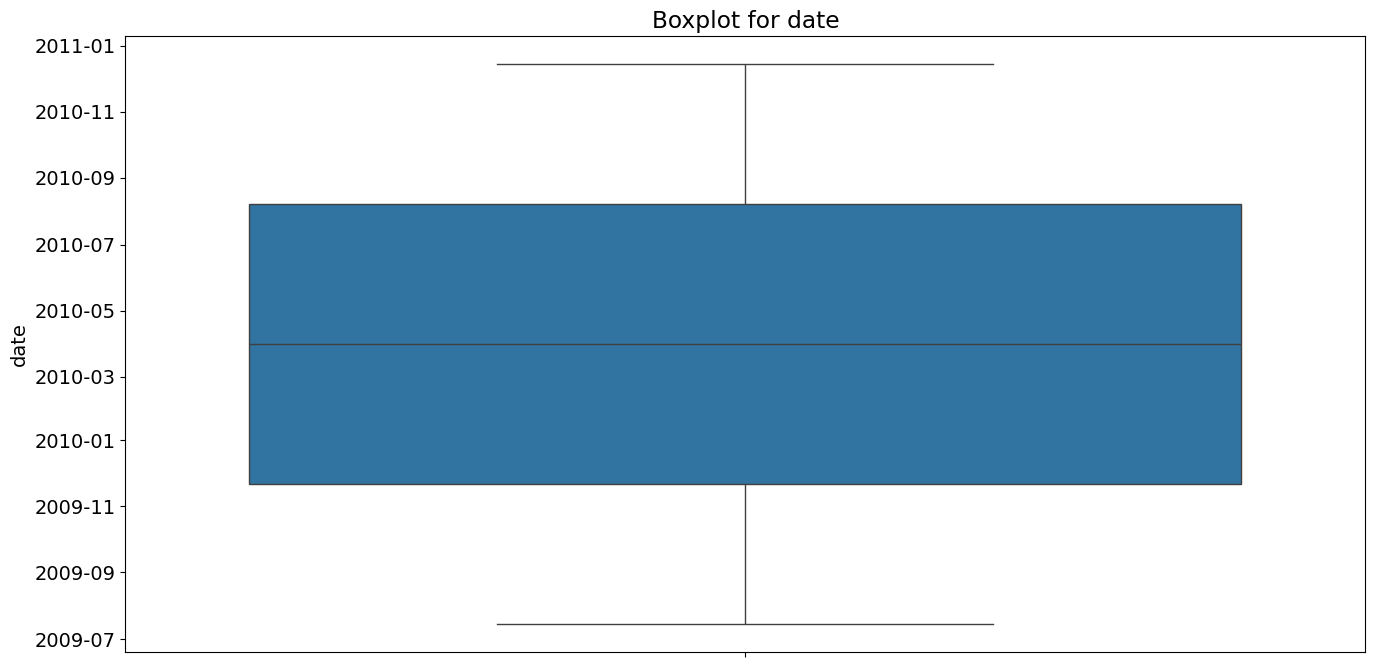

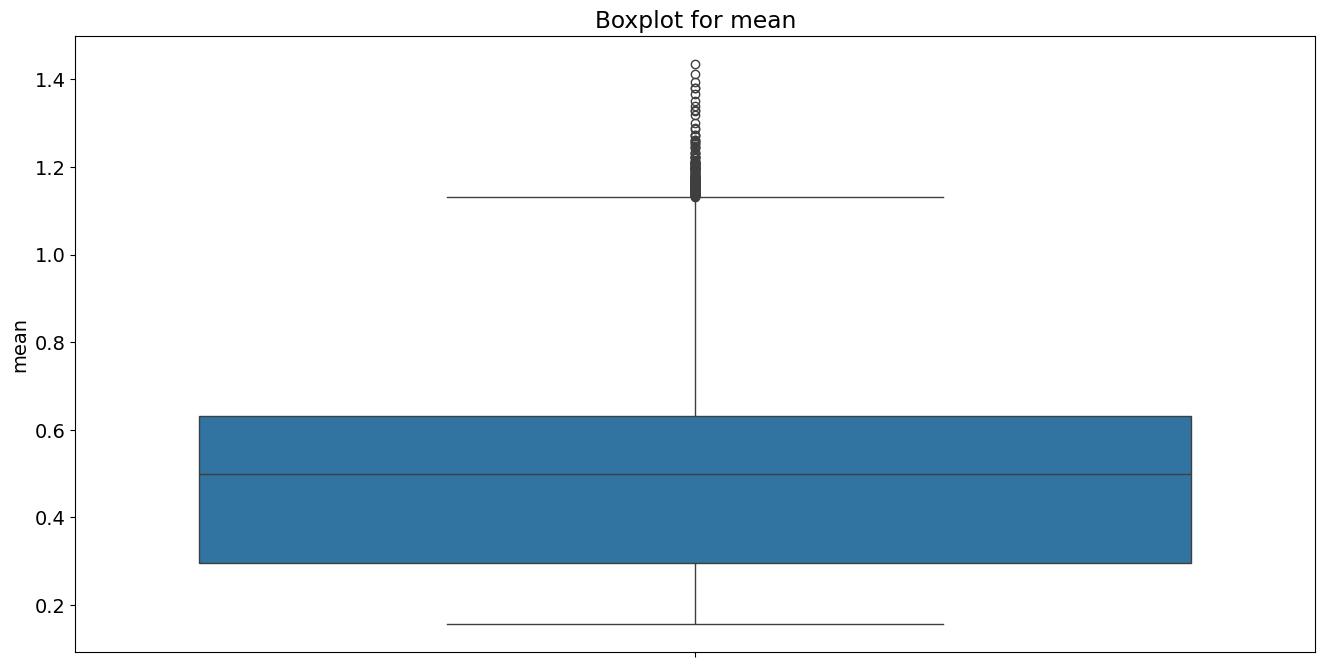

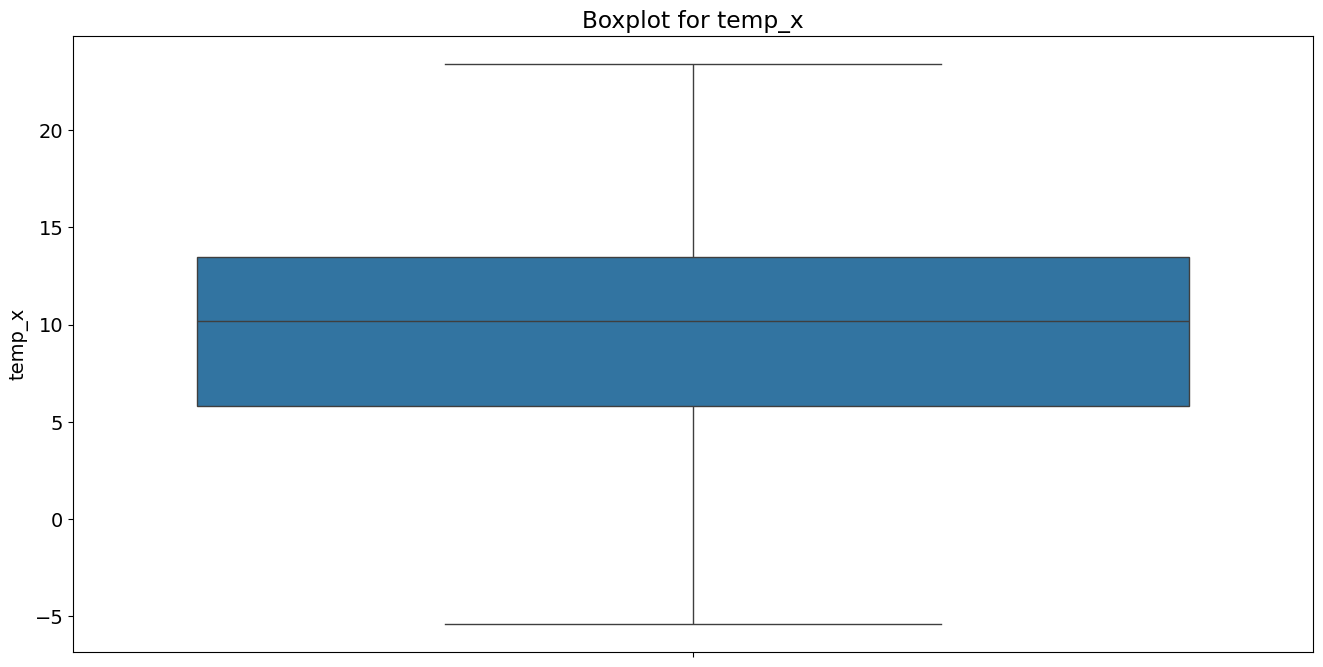

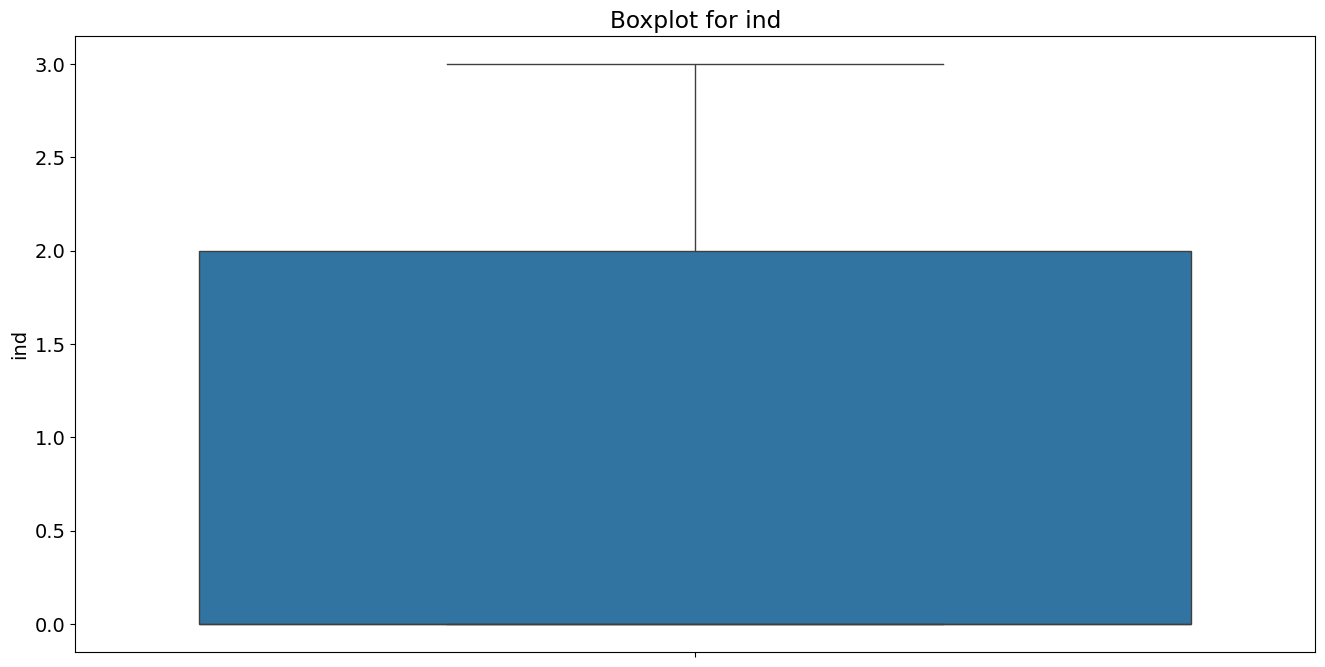

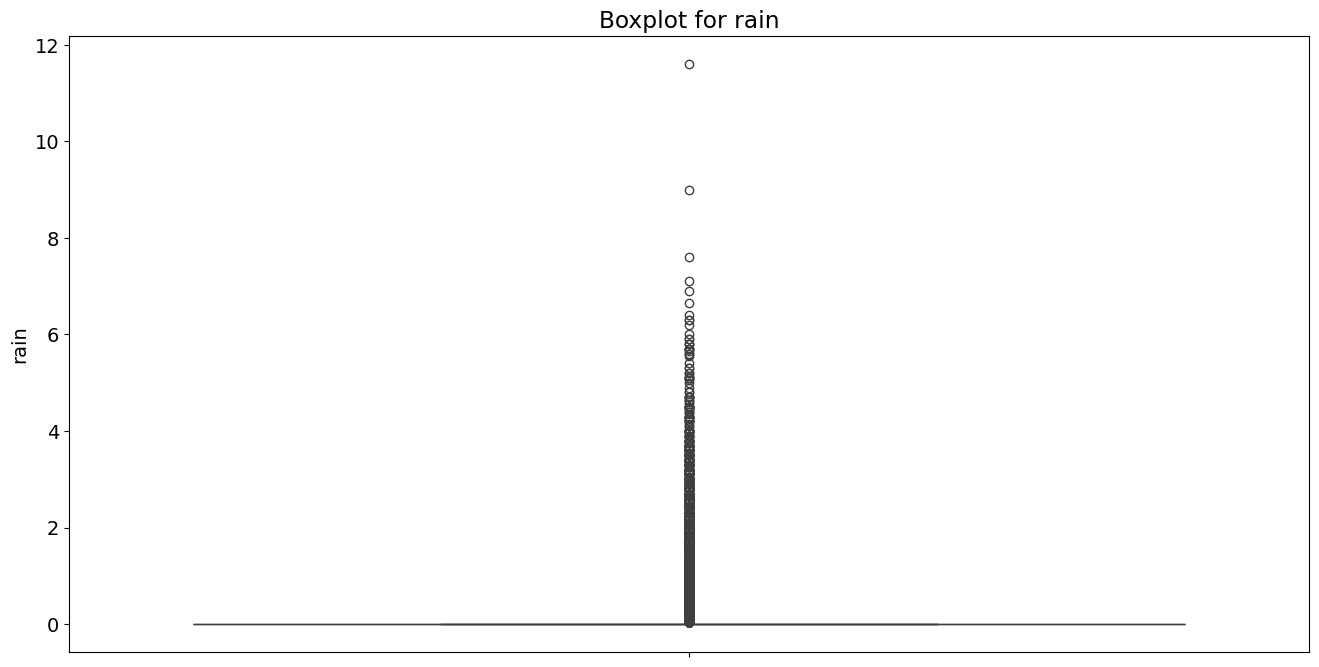

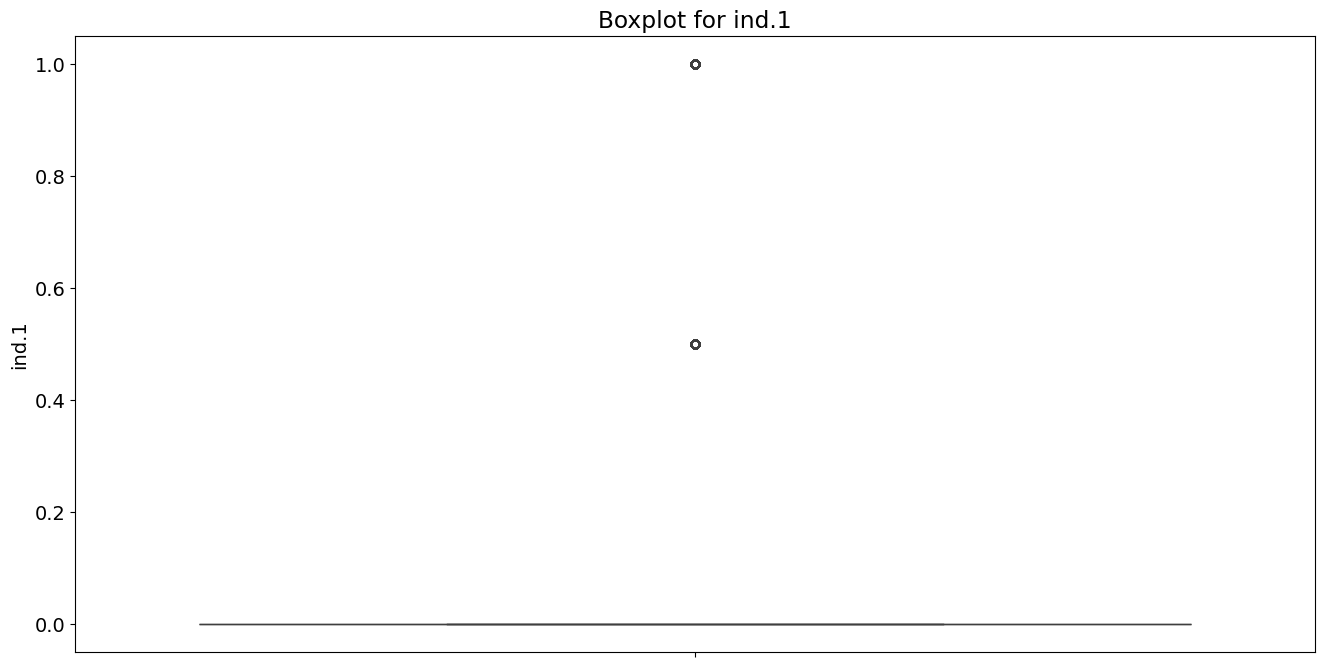

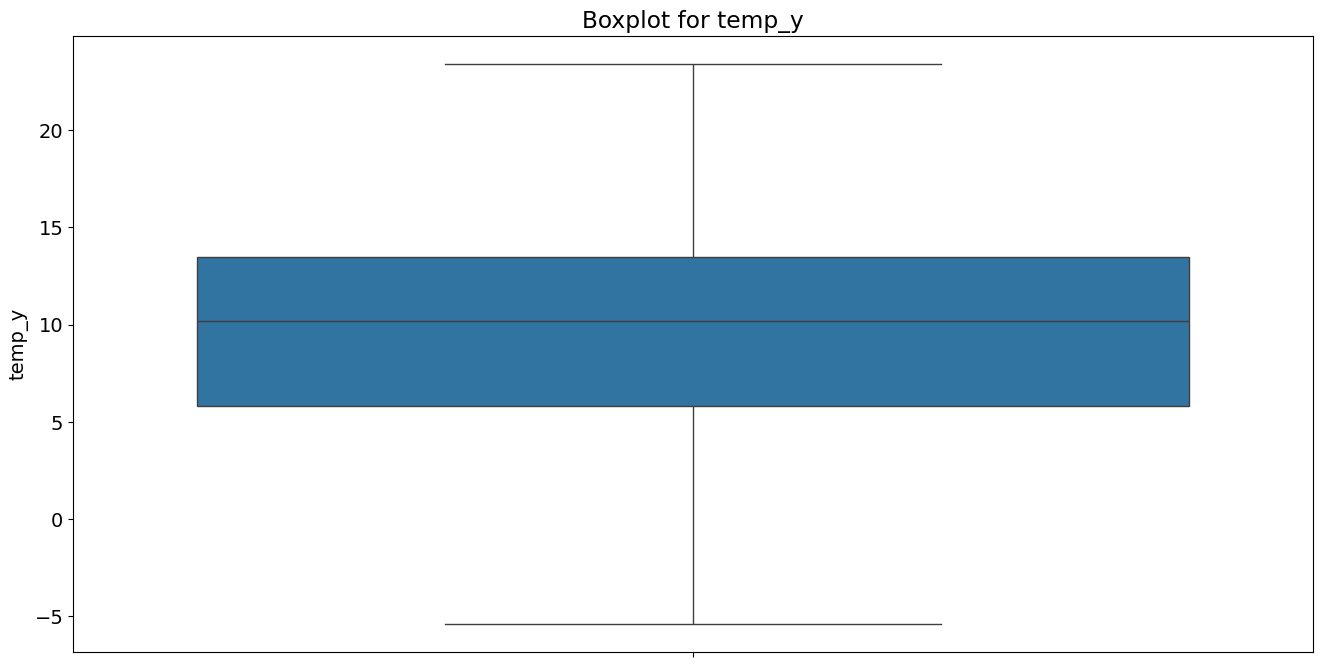

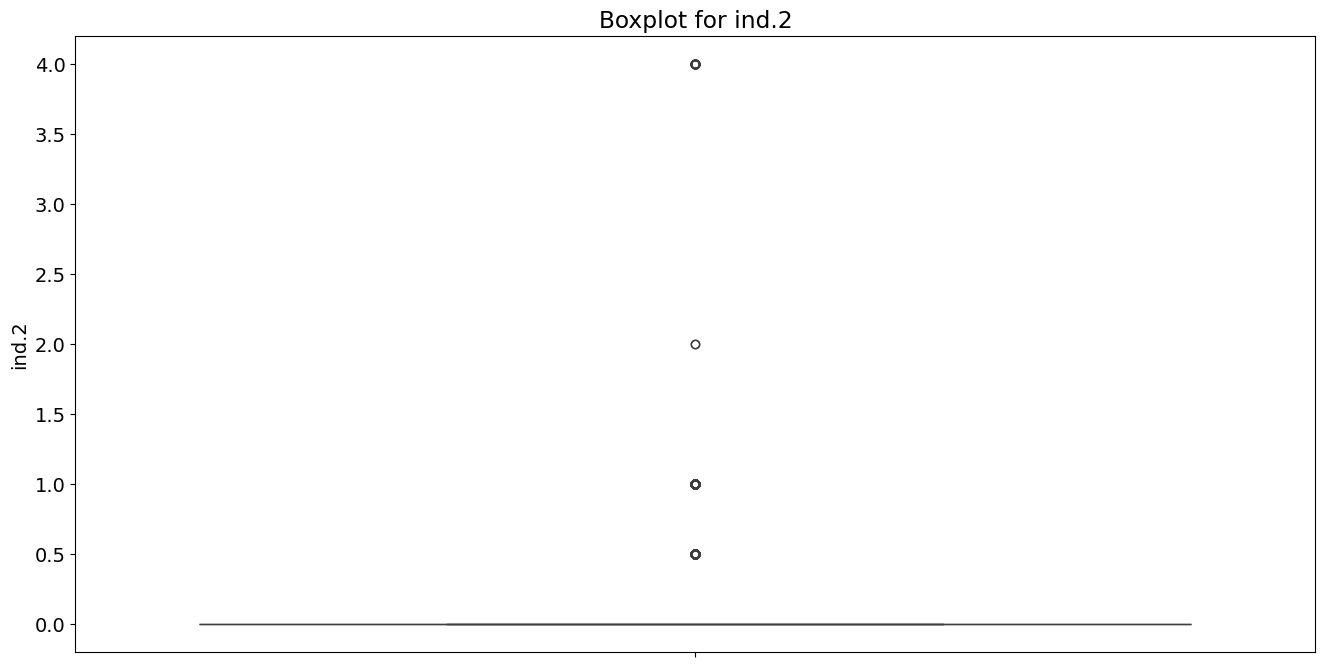

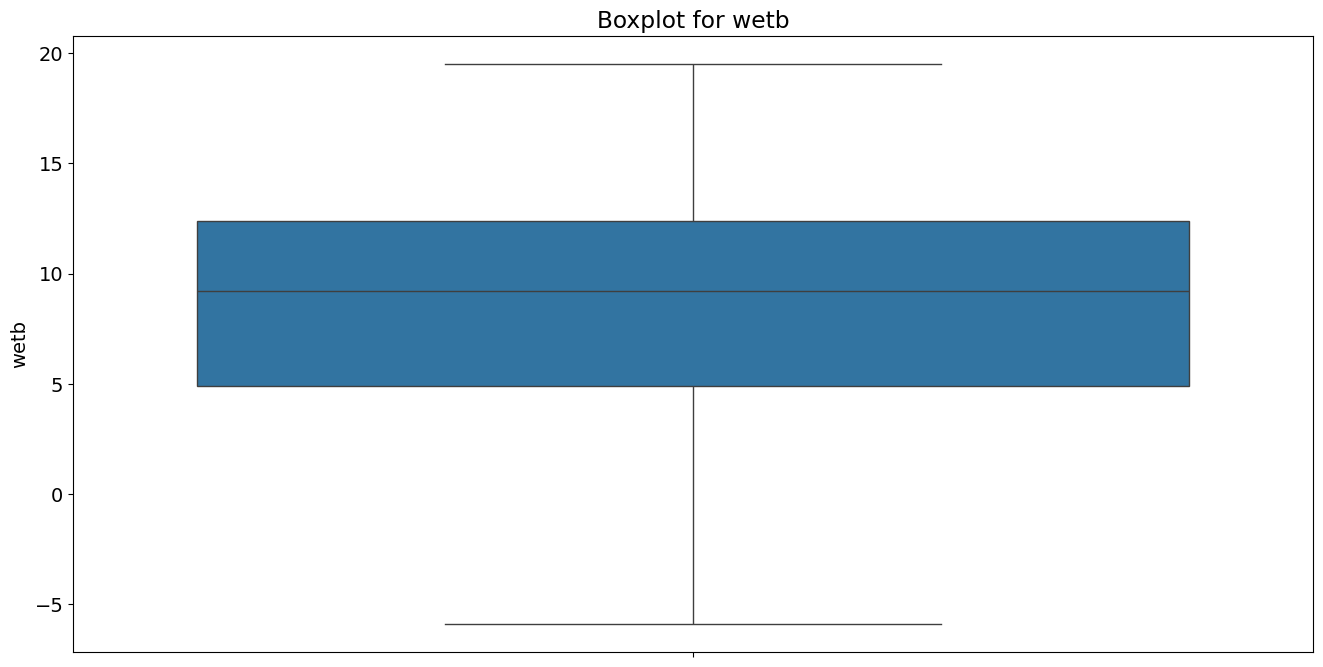

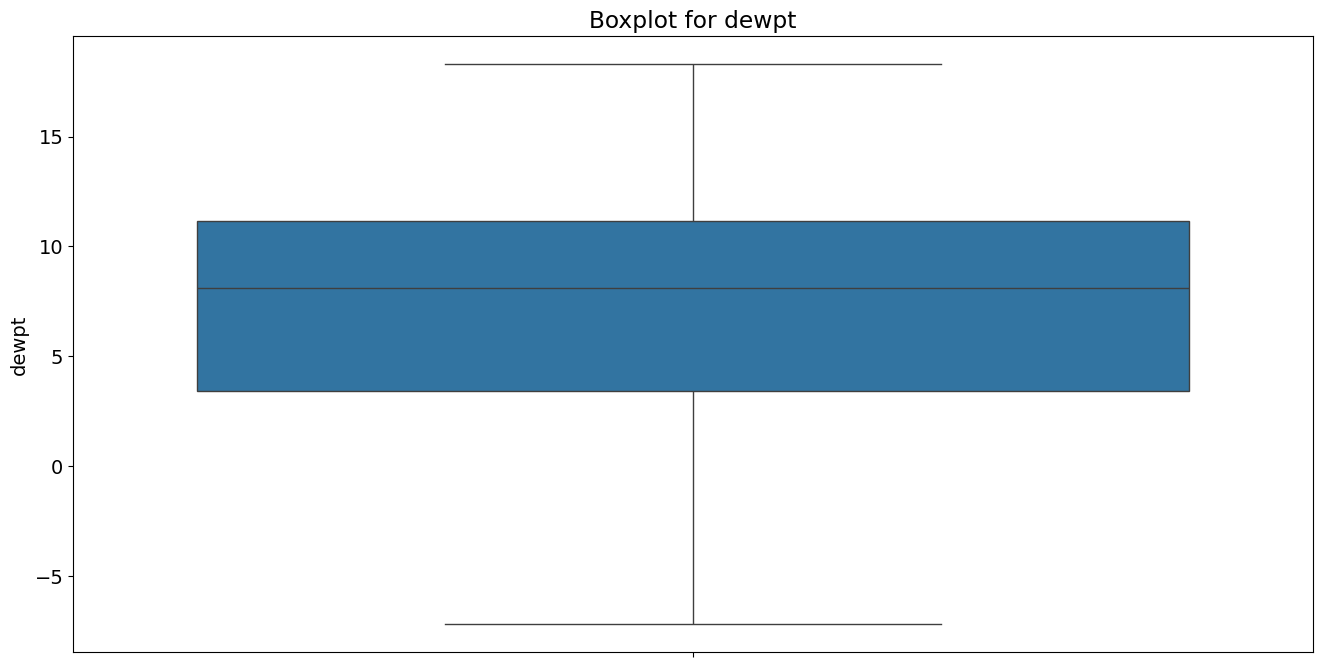

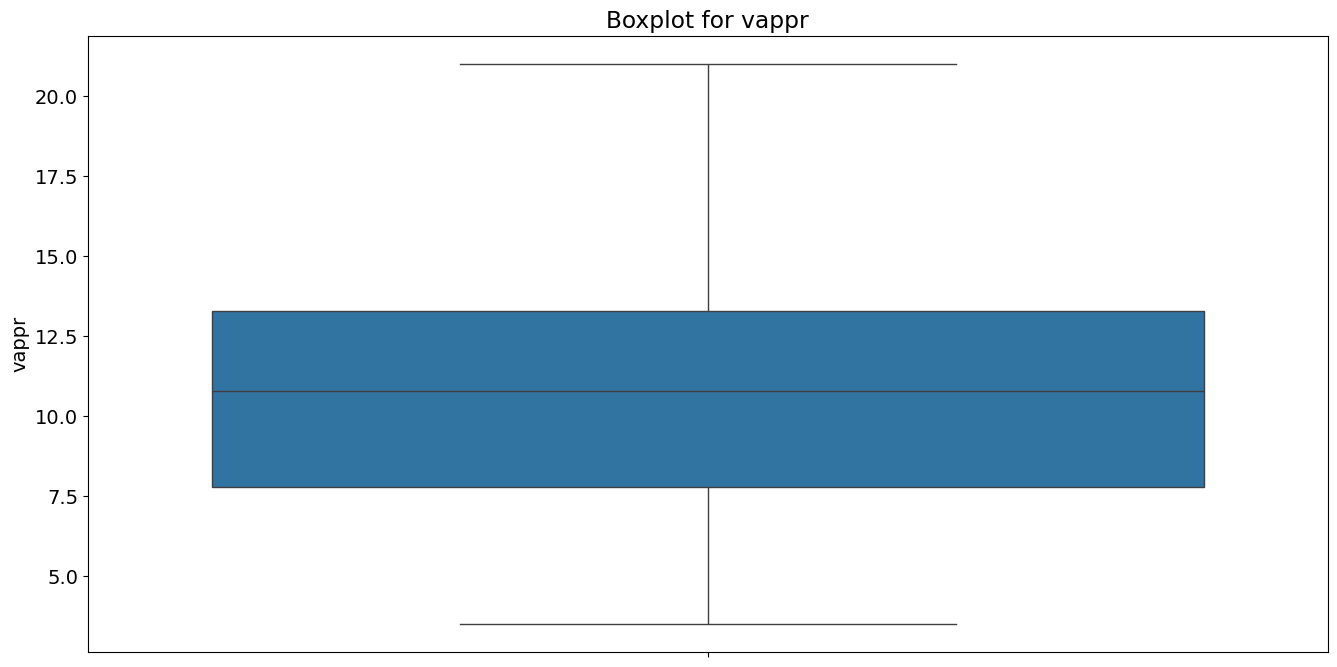

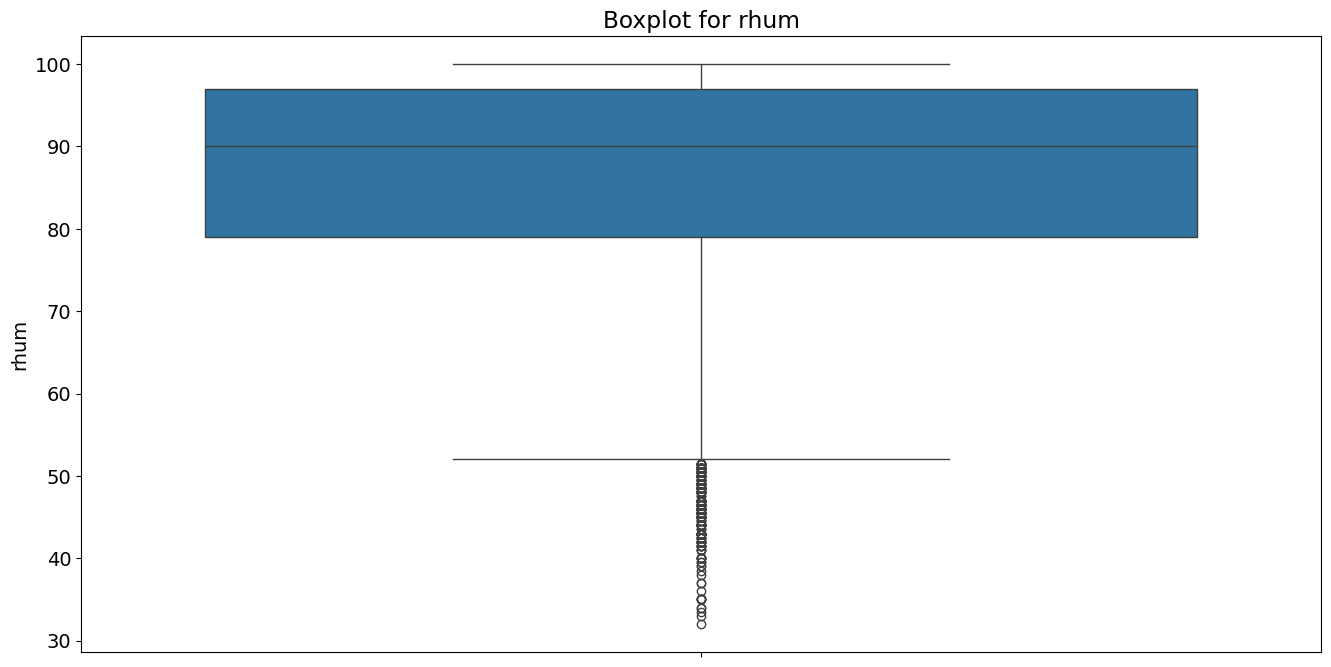

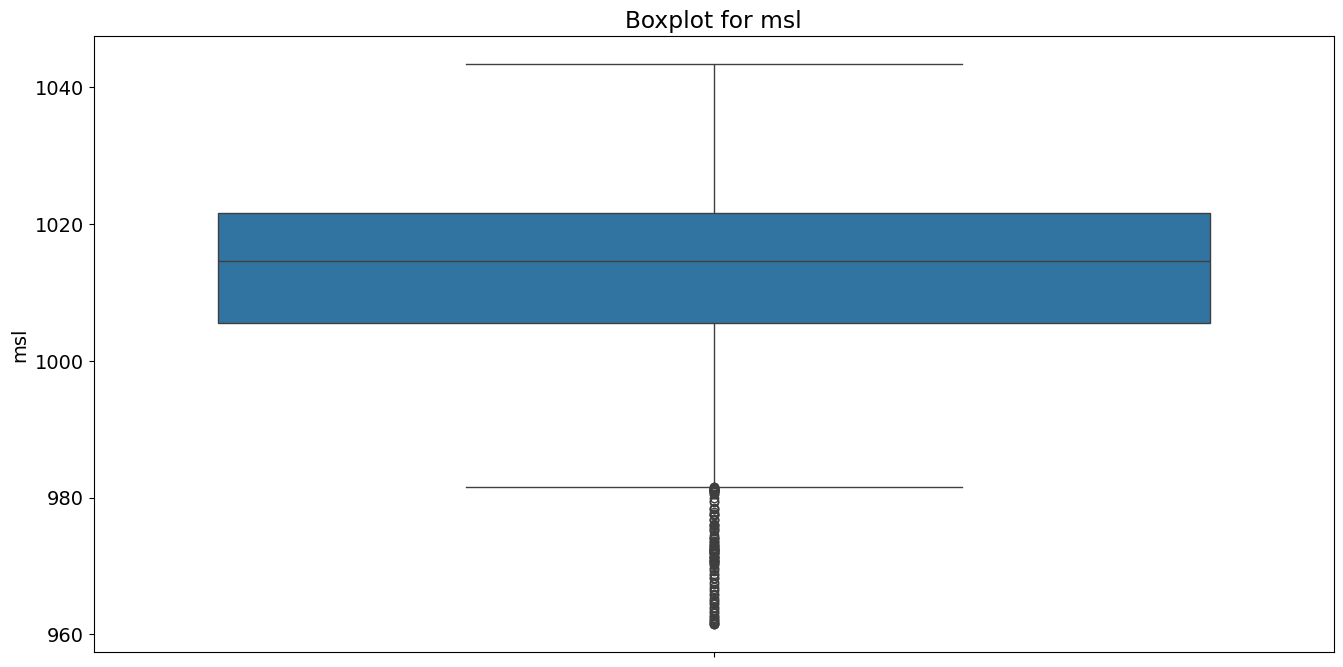

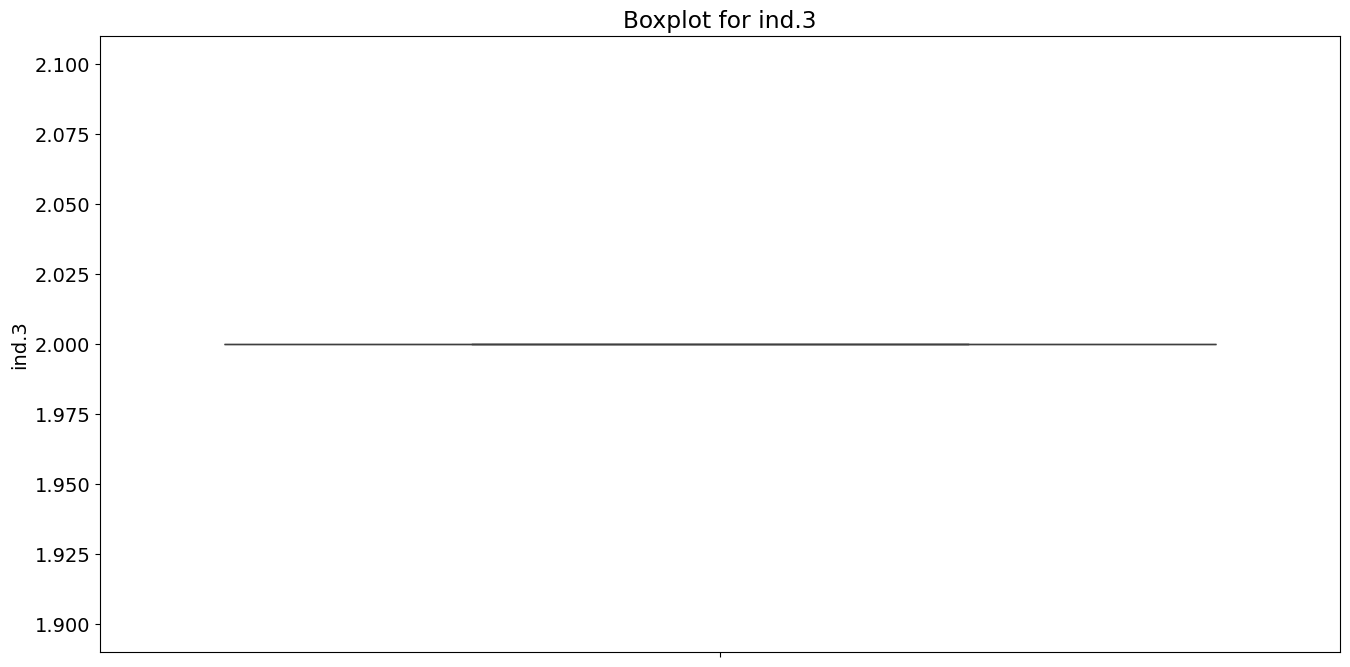

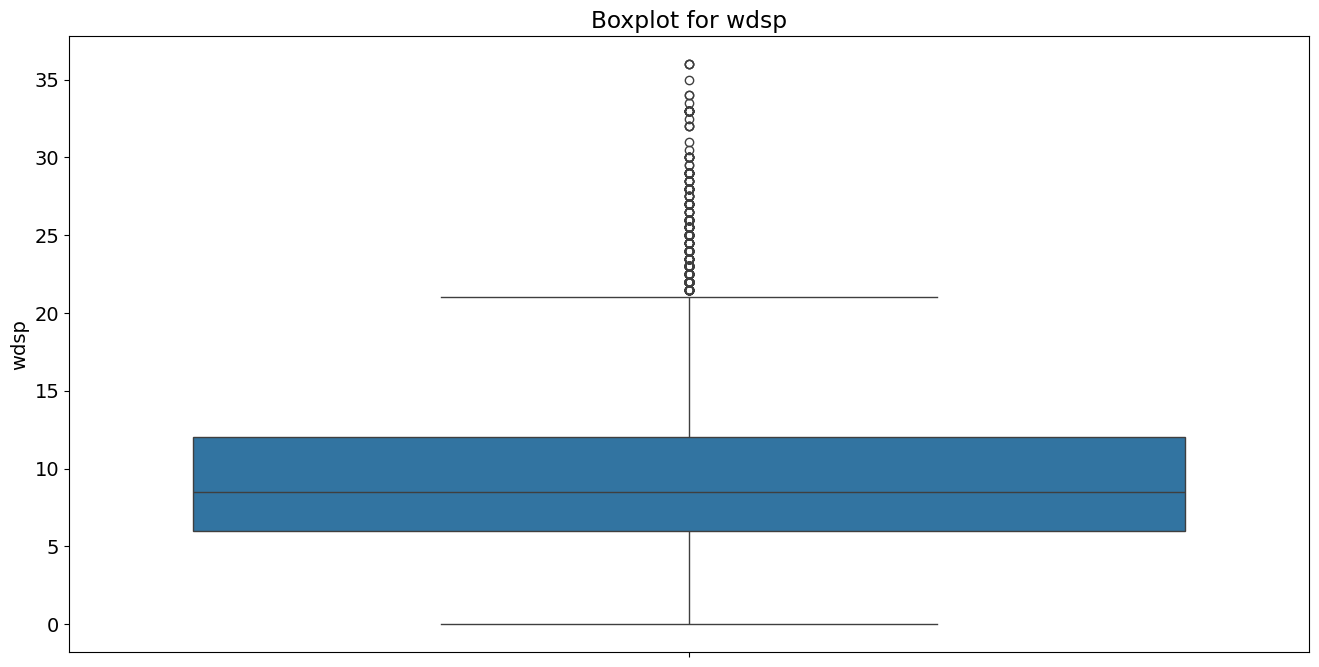

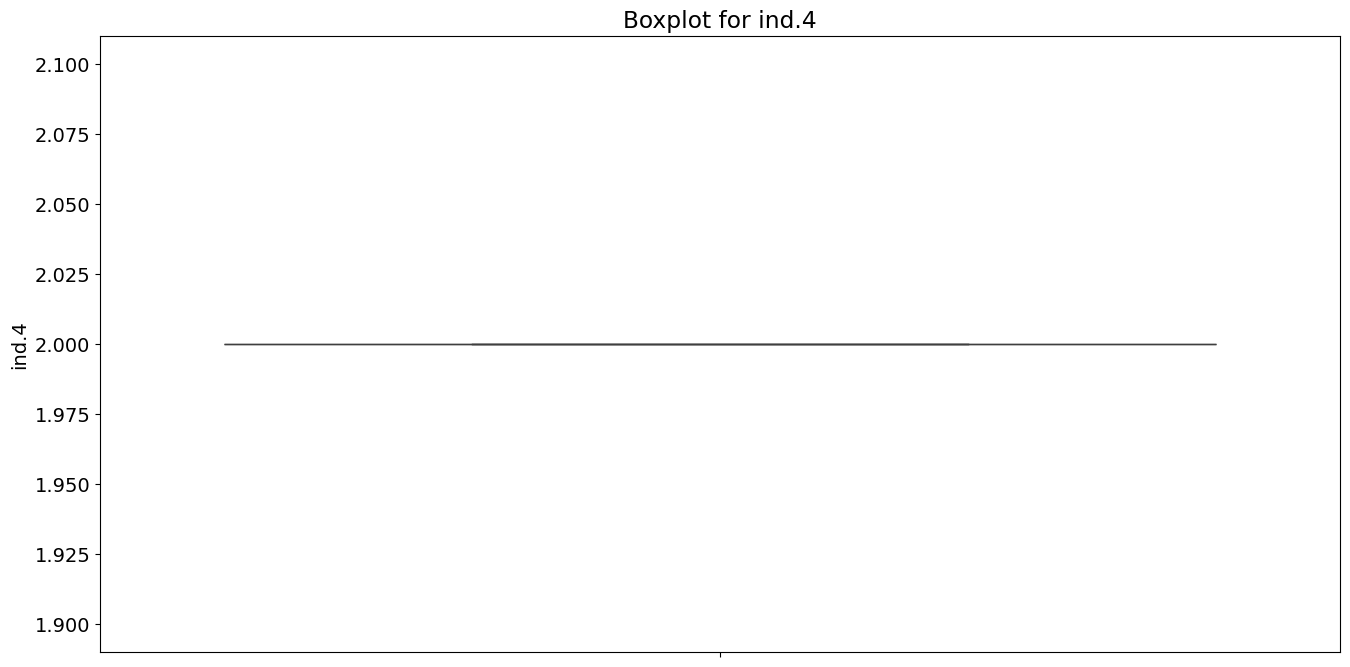

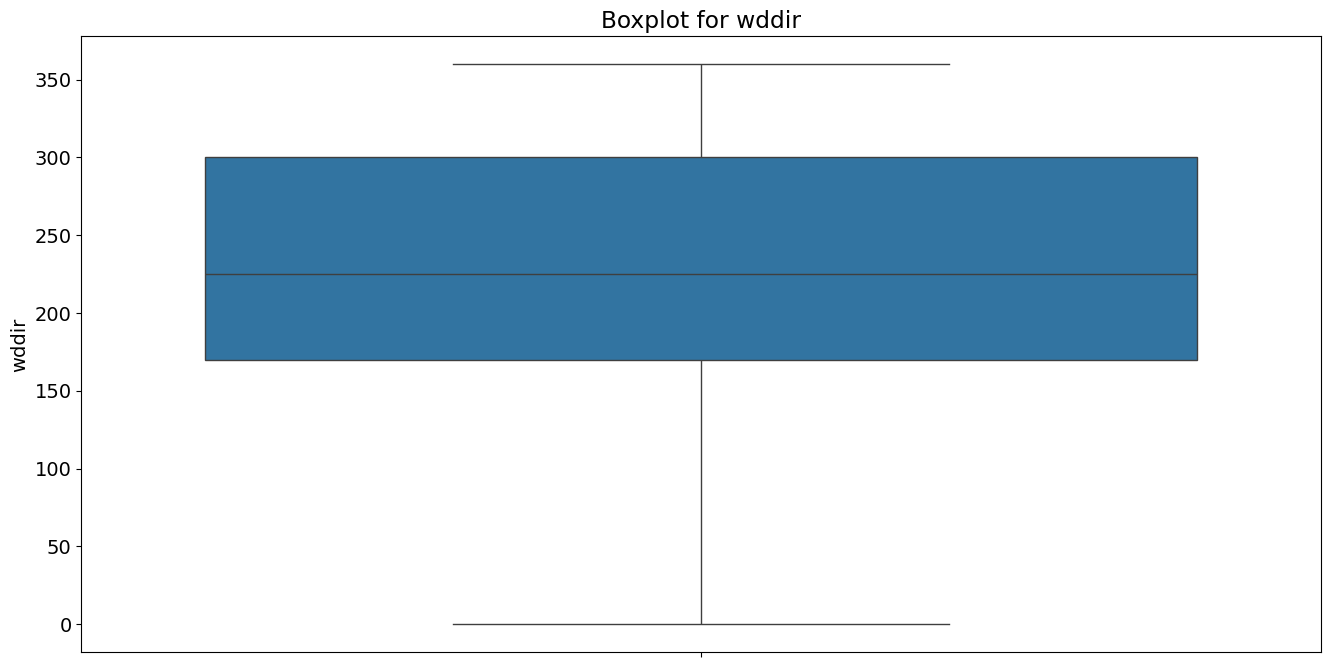

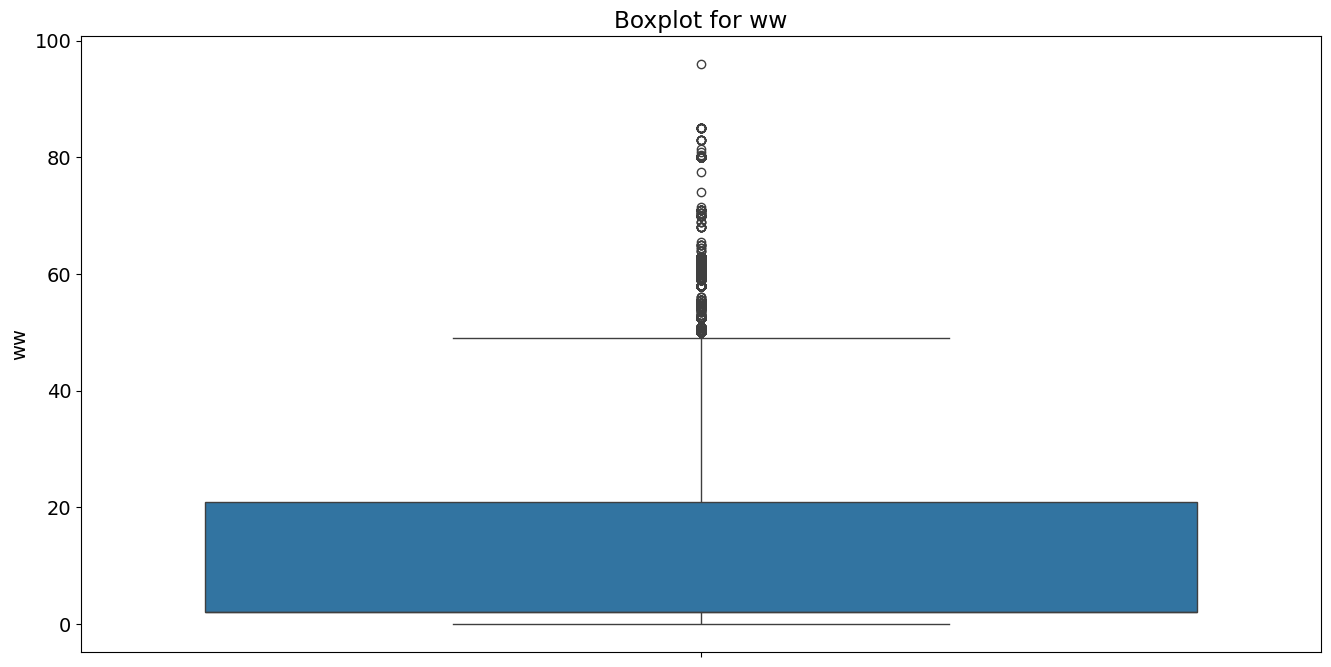

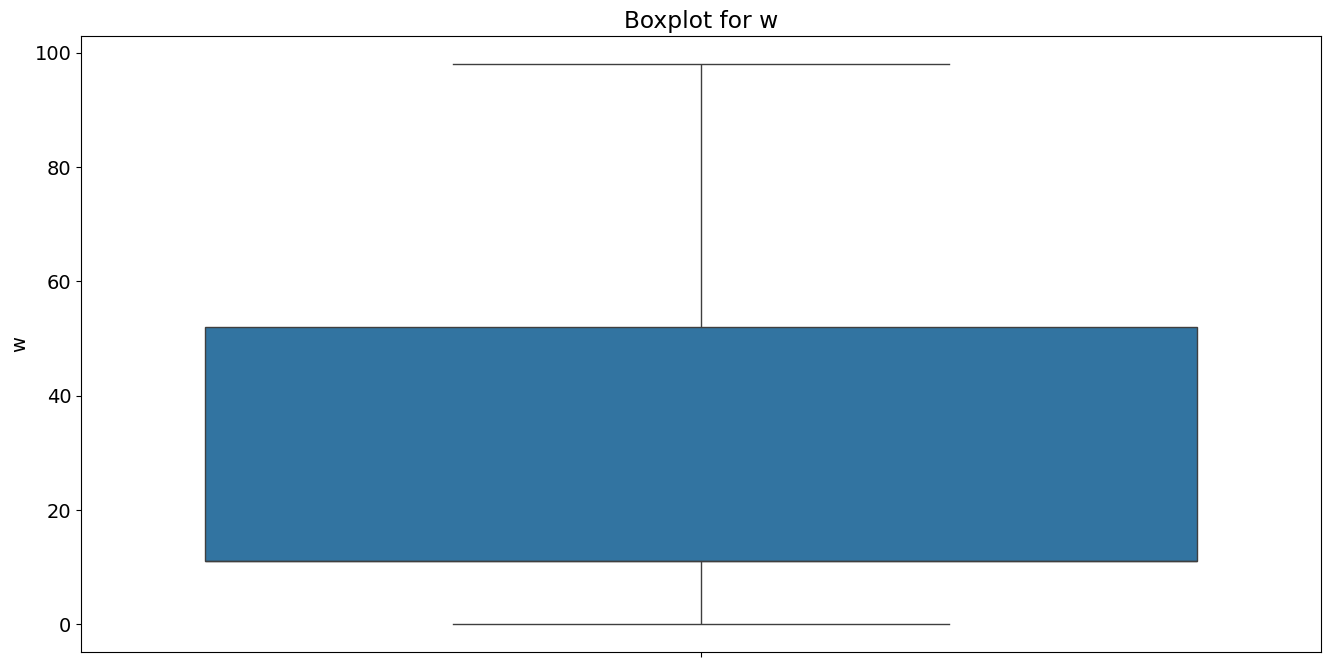

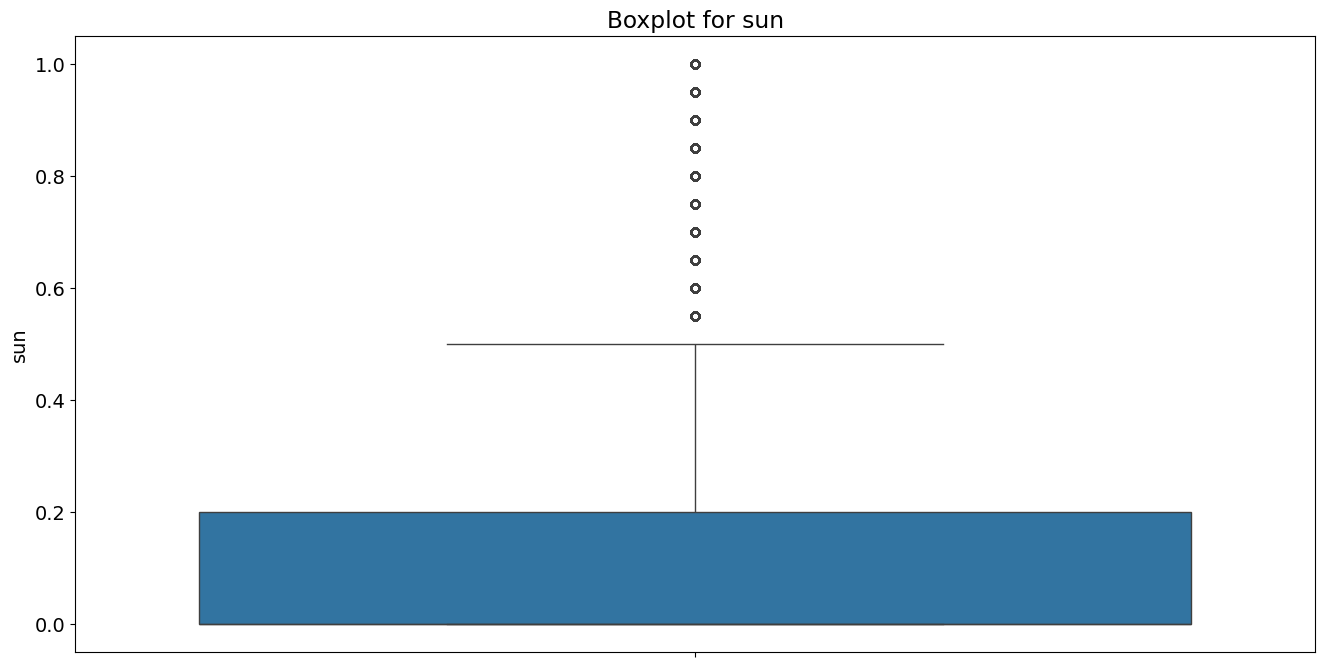

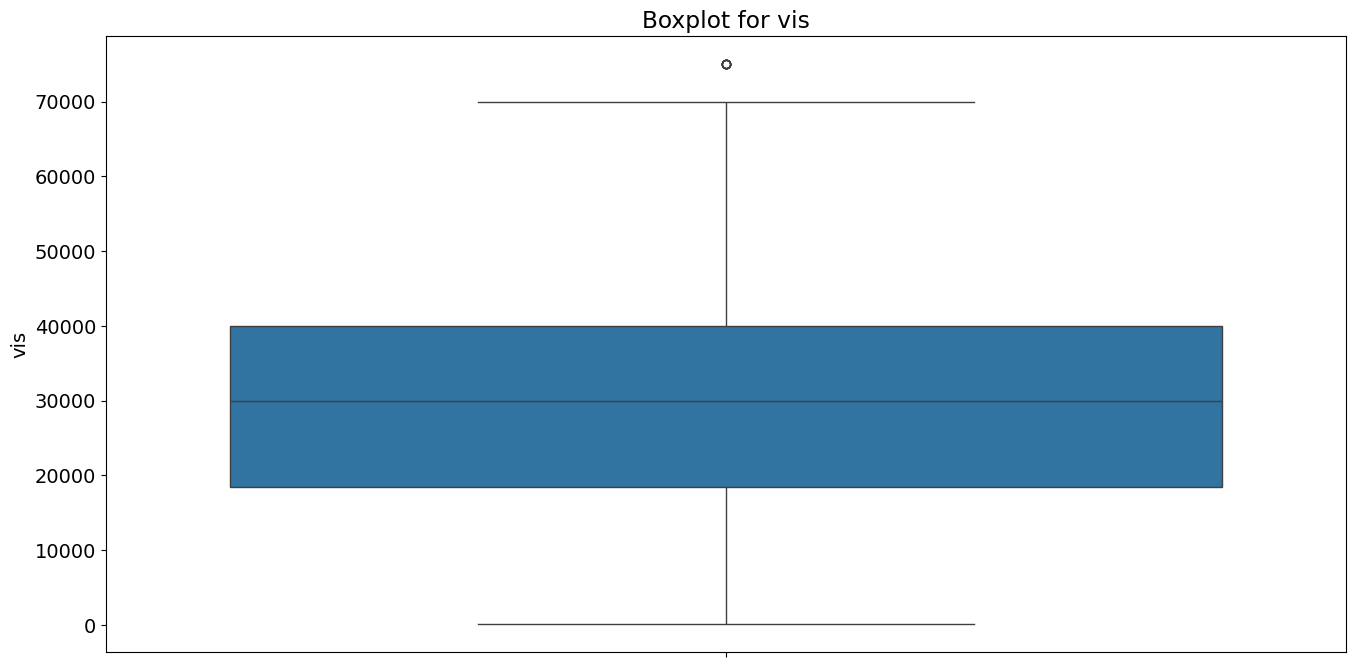

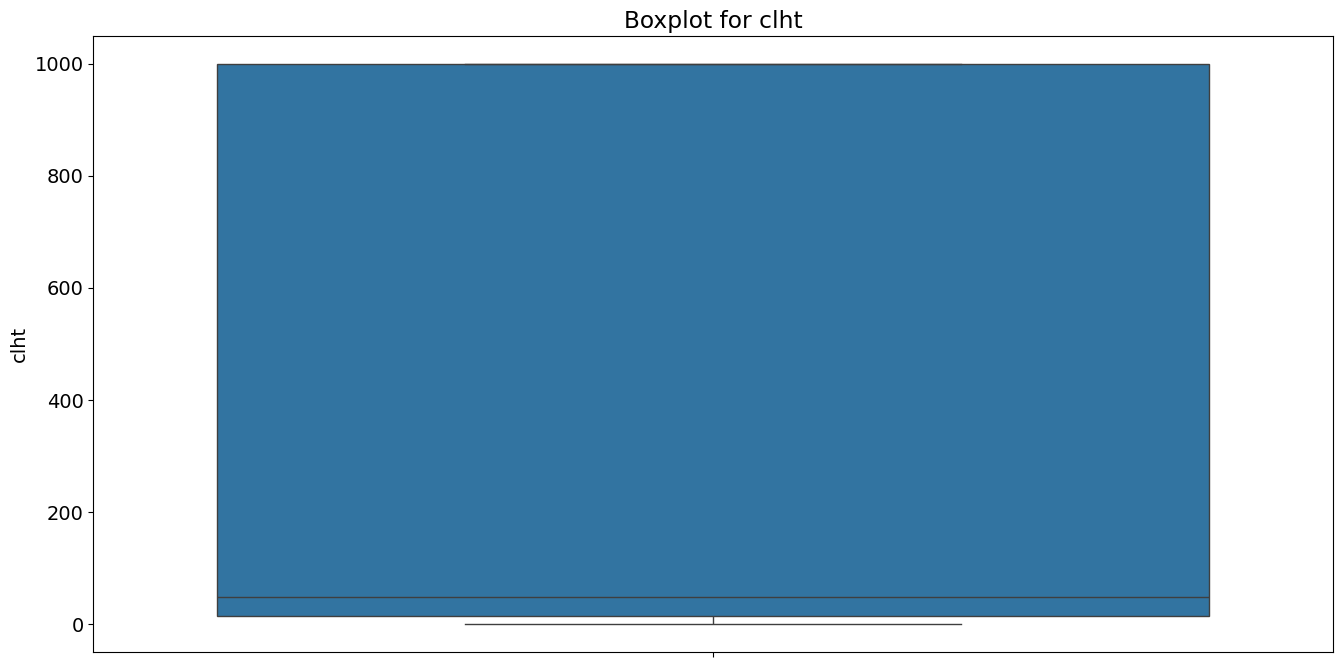

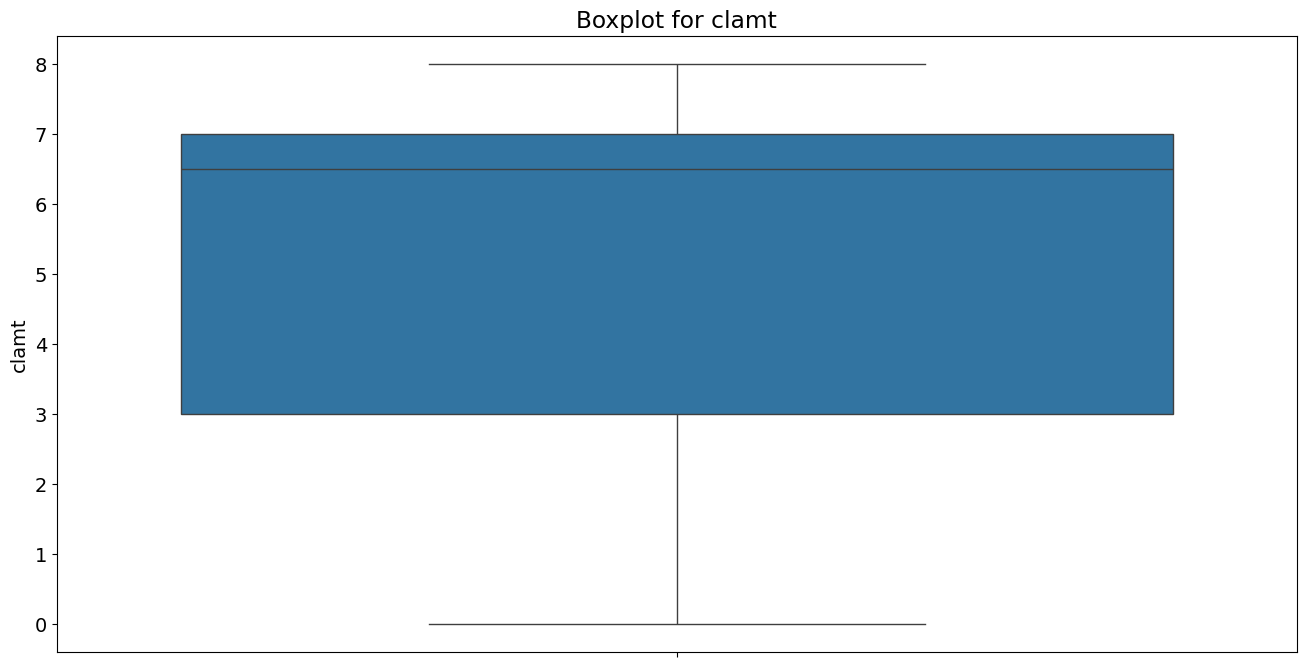

In [ ]:
# Affichage des boxplots pour chaque colonne
plt.figure(figsize=(10, 6))
for index in range(len(df_cleaned_rows.columns)):
  plt.figure()
  sns.boxplot(data=df_cleaned_rows[df_cleaned_rows.columns[index]])
  plt.title("Boxplot for "+str(df_cleaned_rows.columns[index]))
plt.show()

# df_cleaned_rows

Avec ces boxplots, on peut voir qu'il y a des outliars statistiques, mais il faut tout de même les considérer dans la plupart des cas.
En effet les conditions climatiques peuvent présenter des "extrêmes". Par exemple, le boxplot du paramètre "sun" affiche des outliars, mais cela correspond juste à un ensoleillement supérieur à la normale.

Quand même, il y a des colonnes qui n'apportent pas aucune information importante parce que ces colonnes ont toujours la même valeur ('ind.3' et 'ind.4')

In [ ]:
df_cleaned_rows = df_cleaned_rows.drop(columns = ['ind.3','ind.4','temp_y']) # temp_y est égale à temp_x
validation_df = validation_df.drop(columns = ['ind.3','ind.4','temp_y'])

Il faut aussi remarquer que tous les modifications faites dans le DataFrame avec les données à utiliser dans les modèles doivent être faites aussi dans le DF des données à utiliser dans la prediction

II.4 Séparation des données de temps

In [ ]:
df_cleaned_rows['year'] = df_cleaned_rows['date'].dt.year
df_cleaned_rows['month'] = df_cleaned_rows['date'].dt.month
df_cleaned_rows['day'] = df_cleaned_rows['date'].dt.day
df_cleaned_rows['time'] = df_cleaned_rows['date'].dt.time


df_time = df_cleaned_rows['date']

In [ ]:
validation_df['year'] = validation_df['date'].dt.year
validation_df['month'] = validation_df['date'].dt.month
validation_df['day'] = validation_df['date'].dt.day
validation_df['time'] = validation_df['date'].dt.time

II.5 Création de la colonne "is_holiday" pour évaluer la consommation des jours fériés

In [ ]:
holidays = [
    (2009, 8, 3),   # August Holiday - August 3, 2009
    (2009, 10, 26), # October Holiday - October 26, 2009
    (2009, 12, 25), # Christmas Day - December 25, 2009
    (2009, 12, 26), # St. Stephen's Day (Boxing Day) - December 26, 2009
    (2010, 1, 1),   # New Year's Day - January 1, 2010
    (2010, 3, 17),  # St. Patrick's Day - March 17, 2010
    (2010, 4, 2),   # Good Friday - April 2, 2010 (not an official public holiday)
    (2010, 4, 4),   # Easter Sunday - April 4, 2010
    (2010, 4, 5),   # Easter Monday - April 5, 2010
    (2010, 5, 3),   # May Holiday - May 3, 2010
    (2010, 6, 7),   # June Holiday - June 7, 2010
    (2010, 8, 2),   # August Holiday - August 2, 2010
    (2010, 10, 25), # October Holiday - October 25, 2010
    (2010, 12, 25), # Christmas Day - December 25, 2010
    (2010, 12, 26)  # St. Stephen's Day (Boxing Day) - December 26, 2010
]
# Function to check if a given date is a holiday
def is_holiday(row):
    if(row['year'], row['month'], row['day']) in holidays :
      return 1
    else: return 0

# Apply the function to create a new column
df_cleaned_rows['is_holiday'] = df_cleaned_rows.apply(is_holiday, axis=1)
validation_df['is_holiday'] = validation_df.apply(is_holiday, axis=1)


#III. Analyse Exploratoire

III.1 Histogramme, Pairplot et Heatmap de Corrélation

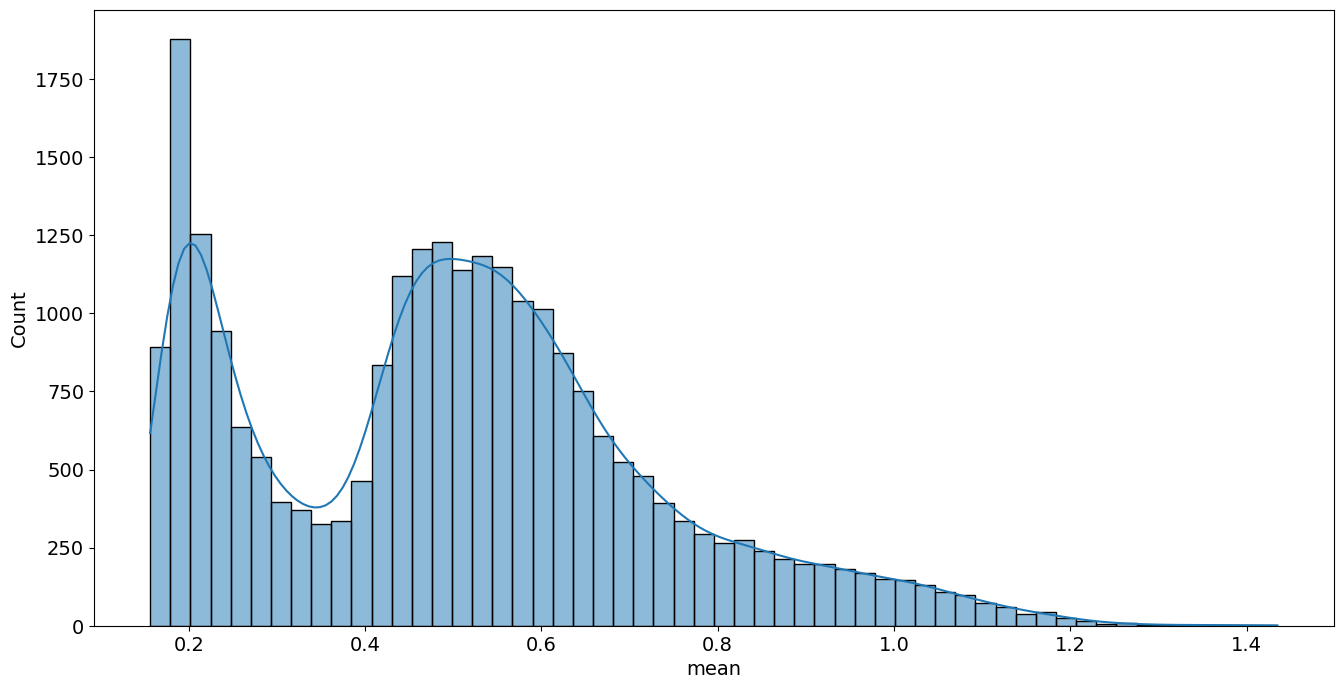

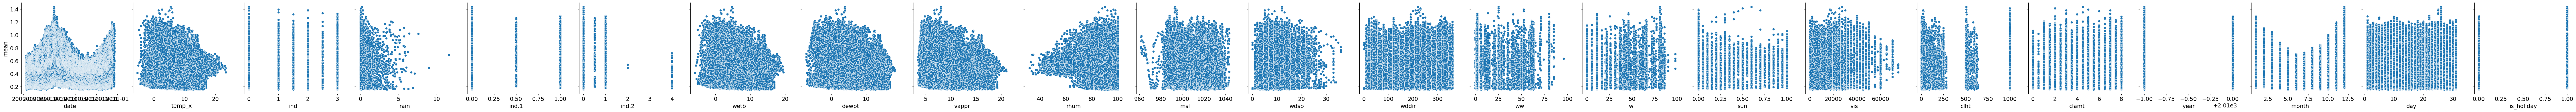

In [ ]:
sns.histplot(df_cleaned_rows['mean'], kde=True)
sns.pairplot(df_cleaned_rows, x_vars=df_cleaned_rows.drop(columns=['mean','time']).columns, y_vars='mean', height=4, aspect=1, kind='scatter')
plt.show()


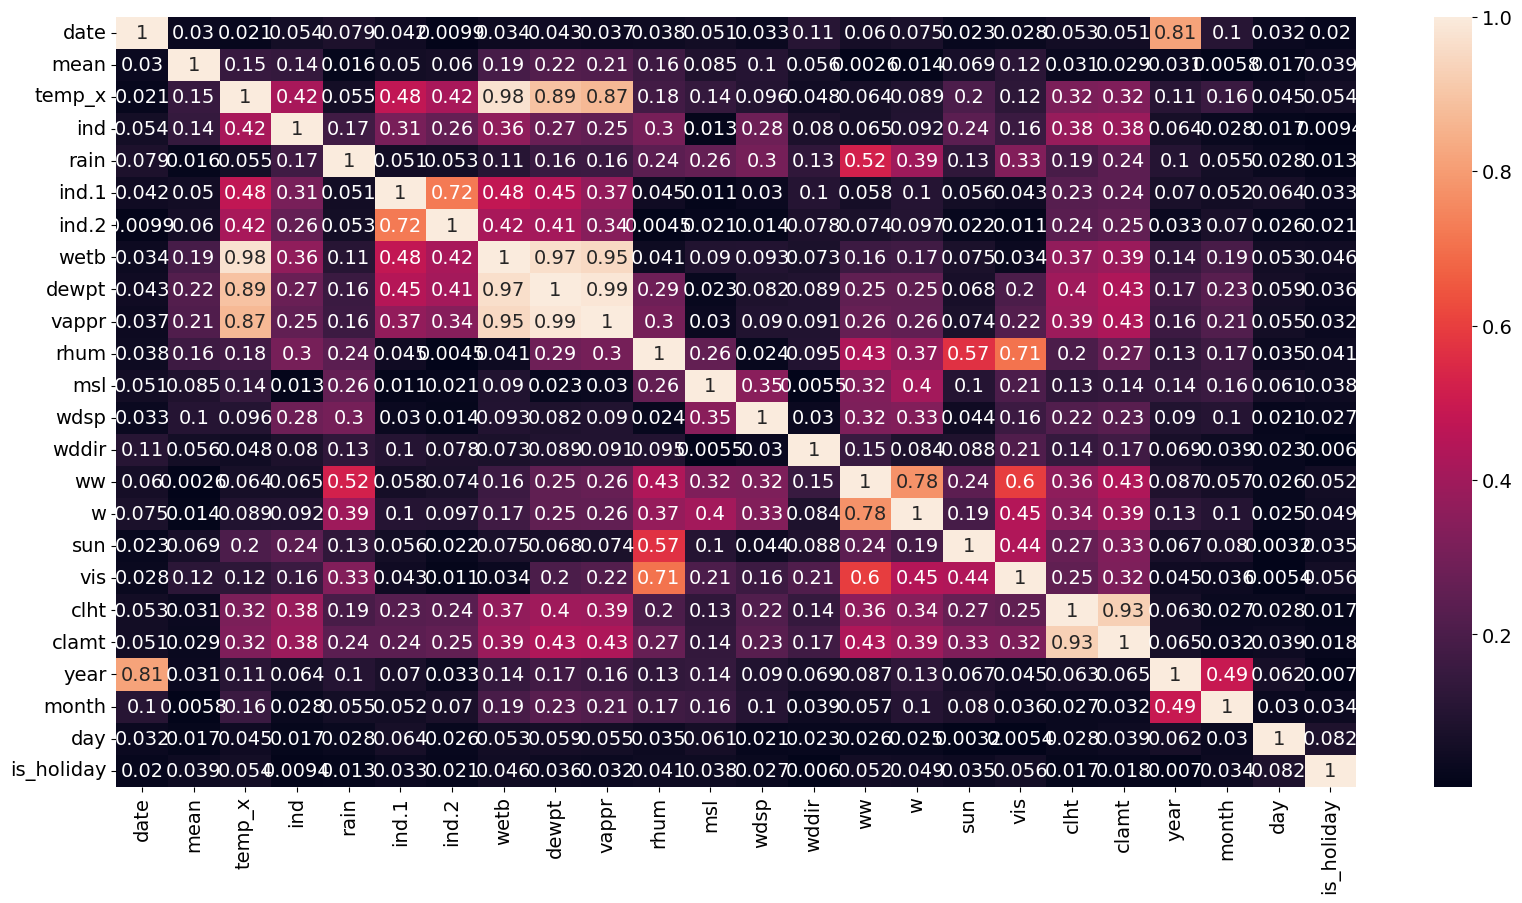

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(np.abs(df_cleaned_rows.drop(columns='time').corr()), annot = True) # corrélation de Pearson
plt.show()

Avec ces résultats, on voit que la variation de consommation pendant une journée ne permet pas de bien trouver les corrélations. Donc il faut faire une analyse en utilisant les données moyennes par jour, pour trouver les bonnes corrélations et nous permettre de bien analyser le modèle

III. 2. Moyennage des consommations sur un journée

III**.2**.a Création d'un fichier avec la consommation moyennée sur une journée

In [ ]:
df_daily_avg = df_cleaned_rows.set_index('date', inplace=True)
df_daily_avg = df_cleaned_rows.drop(columns='time').resample('D').mean()
df_daily_avg.reset_index(inplace=True)
df_daily_avg.rename(columns={'index': 'date'}, inplace=True)
df_cleaned_rows.reset_index(inplace=True)
df_cleaned_rows.rename(columns={'index': 'date'}, inplace=True)

III.2.b Histogramme, Pairplot et Corrélation pour le DF moyenne par jour

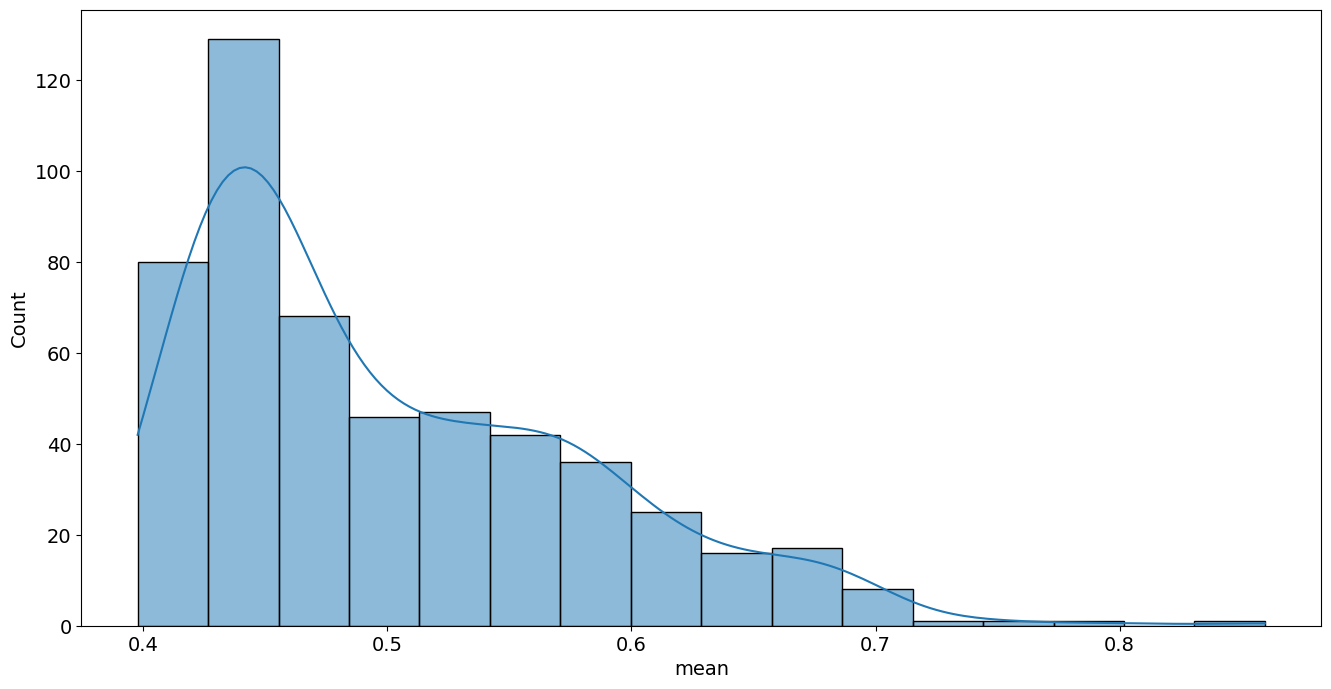

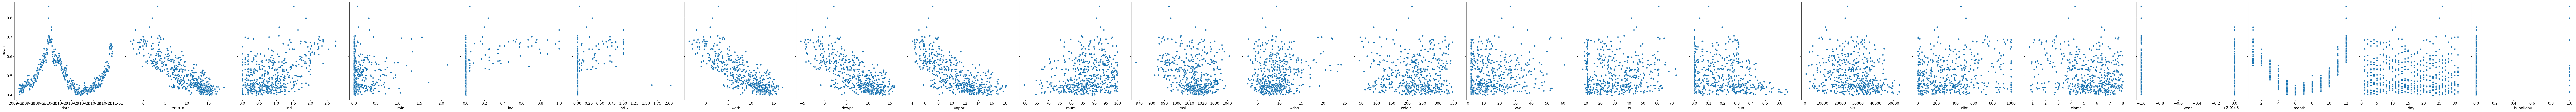

In [ ]:
sns.histplot(df_daily_avg['mean'], kde=True)
sns.pairplot(df_daily_avg, x_vars=df_cleaned_rows.drop(columns=['mean','time']).columns, y_vars='mean', height=6, aspect=1, kind='scatter')
plt.show()

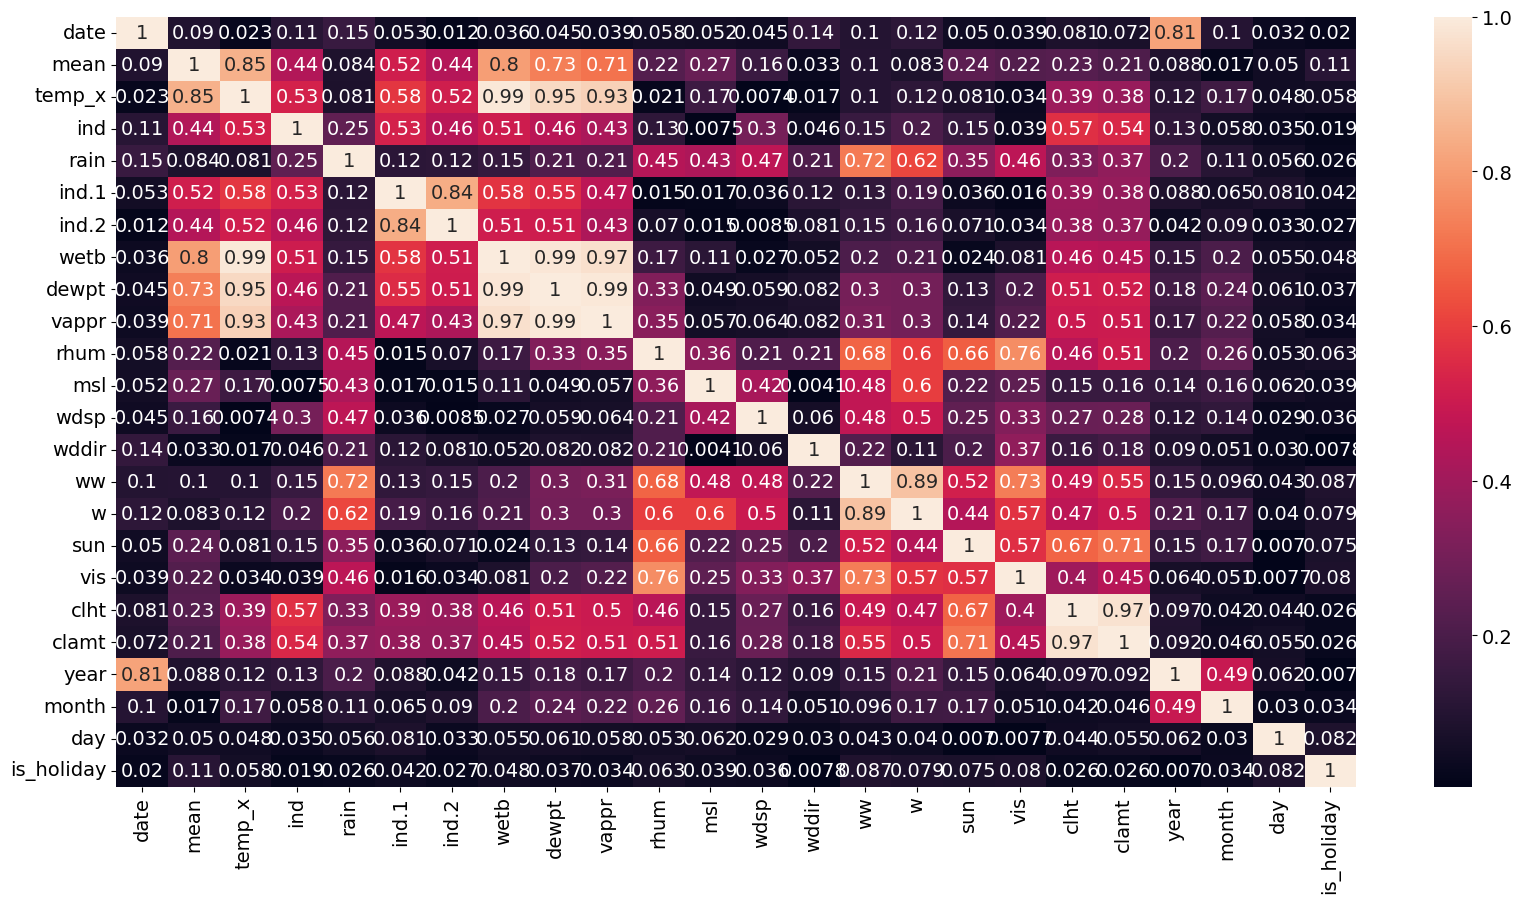

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(abs(df_daily_avg.corr()), annot = True) # corrélation de Pearson
plt.show()

III.3 Etude des corrélations et réduction du nombre de variables

On peut identifier et faire un drop des variables qui ont une forte corrélation.

Paramètres dépendants

*   de la témperature: 'wetb','dewpt','vappr' - Haute corrélation avec la témperature
*   de 'ind.2': Haute corrélation avec 'ind.1''
*   de 'ww': Haute corrélation avec 'w'
*   de la visibilité et nuages: 'clht', 'clamt', 'rhum', 'vis' - Haute corrélation avec le soleil 'sun'

On remarque que nous avons gardé le DataFrame avec les données complets pour faire une comparaison des modèles faites avec la DF complète et la DF réduite



III.3.a réduction du nombre de variables

In [ ]:
df_cleaned_dropped = df_cleaned_rows.drop(columns=['wetb','dewpt','vappr','ind.2',
                                                   'ww','clht', 'clamt','rhum', 'vis'])
validation_dropped_df = validation_df.drop(columns=['wetb','dewpt','vappr','ind.2',
                                                   'ww','clht', 'clamt','rhum', 'vis'])

III.3.b Comparaison des corrélations avant et après réduction du nombre de variables  

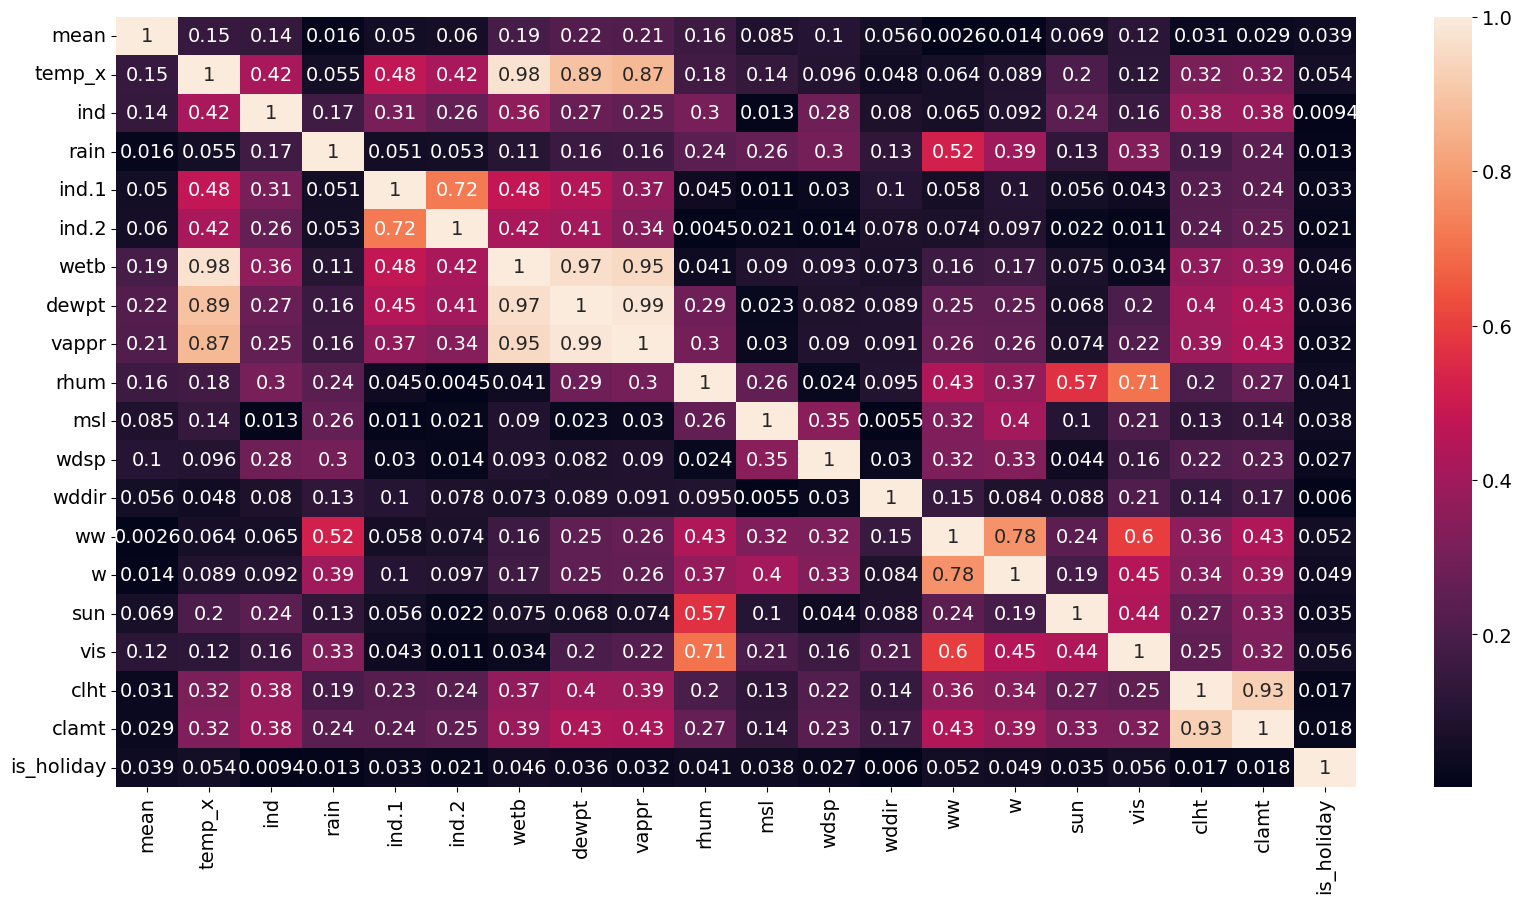

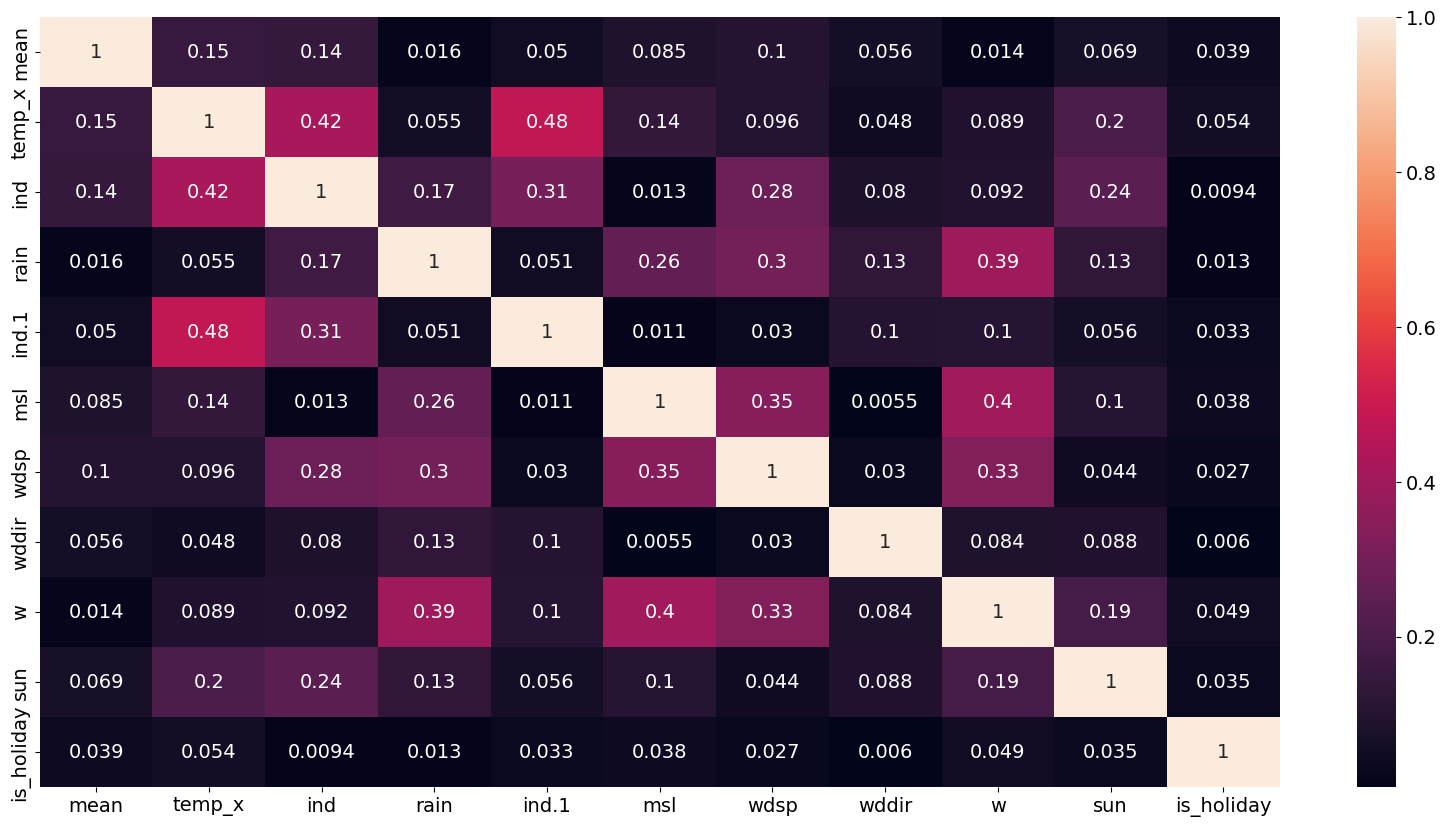

In [ ]:
#CORRELATION MODELE COMPLETE
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(abs(df_cleaned_rows.drop(columns=['time', 'date','day','month','year']).corr()), annot = True) # corrélation de Pearson
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(abs(df_cleaned_dropped.drop(columns=['time', 'date','day','month','year']).corr()), annot = True) # corrélation de Pearson
plt.show()


III.4 Normalisation / Standardization

On a fait juste une simple normalisation (subtraction de la moyenne et division par l'écart type)

On remarque que nous avons gardé le DataFrame avec les données non-normalisés pour faire une comparaison des modèles.

On aura donc 4 DFs: X complète, X réduite, X complète normalisé et X réduite normalisé

In [ ]:
#Takes the columns of df_cleaned_rows except the ones specified in difference
cols_to_normalize = df_cleaned_rows.columns.difference(['date','year','month','day','time','is_holiday','mean'])

#Create a copy of df_cleaned_rows
df_cleaned_rows_norm = df_cleaned_rows.copy()
validation_norm_df = validation_df.copy()

#Normalize the copy of df_cleaned_rows by subtracting the mean and dividing by the standart deviation
df_cleaned_rows_norm[cols_to_normalize] = df_cleaned_rows[cols_to_normalize].apply(lambda x: (x - x.mean()) / x.std())
validation_norm_df[cols_to_normalize] = validation_df[cols_to_normalize].apply(lambda x: (x - x.mean()) / x.std())

cols_to_normalize = df_cleaned_dropped.columns.difference(['date','year','month','day','time','is_holiday','mean'])

df_cleaned_dropped_norm = df_cleaned_dropped.copy()
validation_dropped_norm_df = validation_dropped_df.copy()

df_cleaned_dropped_norm[cols_to_normalize] = df_cleaned_rows[cols_to_normalize].apply(lambda x: (x - x.mean()) / x.std())
validation_dropped_norm_df[cols_to_normalize] = validation_dropped_df[cols_to_normalize].apply(lambda x: (x - x.mean()) / x.std())

#display(df_cleaned_rows_norm, df_cleaned_dropped_norm)

III.5 Modulation du temps par sin/cos dans les 4 DFs (Complet, Variables sélectionnées, Complet Normalisé et V.S. Normalisé)

In [ ]:
# Extract date-related features
df_x = df_cleaned_rows.copy()
df_x_drop = df_cleaned_dropped.copy()
df_x_norm = df_cleaned_rows_norm.copy()
df_x_drop_norm = df_cleaned_dropped_norm.copy()

def modulate_df(df):
  df['day_of_week'] = df['date'].dt.dayofweek
  df['hour'] = df['date'].dt.hour

  # Encode cyclical features
  df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
  df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
  df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
  df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
  df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
  df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

  df = df.drop(columns=['hour','day_of_week','year','month','day','time','date'])

  return df

df_x = modulate_df(df_x)
df_x_drop = modulate_df(df_x_drop)
df_x_norm = modulate_df(df_x_norm)
df_x_drop_norm = modulate_df(df_x_drop_norm)

X_full = df_x.copy() # Sauvegarde d'une DF avec tous les données de temps
X_full['date'] = df_cleaned_rows['date']


Il faut faire la même chose pour les 4 DFs avec données utilisés pour la prédiction/validation

In [ ]:
df_validation = validation_df.copy()
df_validation_dropped = validation_dropped_df.copy()
df_validation_norm = validation_norm_df.copy()
df_validation_dropped_norm = validation_dropped_norm_df.copy()

df_validation = modulate_df(df_validation)
df_validation_dropped = modulate_df(df_validation_dropped)
df_validation_norm = modulate_df(df_validation_norm)
df_validation_dropped_norm = modulate_df(df_validation_dropped_norm)


III.6 Dataframe disponibles

In [ ]:
#DATAFRAMES:

Y = df_x['mean'] # Database de consommation relatif à ce modèle

# X = Dataframe complète traité
X = df_x.drop(columns='mean')

# XR = Dataframe réduite
XR = df_x_drop.drop(columns='mean')

# XN = Dataframe complète traité NORMALISÉ
XN = df_x_norm.drop(columns='mean')

# XRN = Dataframe réduite NORMALISÉ
XRN = df_x_drop_norm.drop(columns='mean')

#DATAFRAMES to validate the model (period to be predicted):
X_valid = df_validation.drop(columns='mean')

X_valid_R = df_validation_dropped.drop(columns='mean')

X_valid_N = df_validation_norm.drop(columns='mean')

X_valid_RN = df_validation_dropped_norm.drop(columns='mean')

#IV. Modèles de Prédiction

In [ ]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

columns = [' Model ',' DF Utilisé ',' Train Split ',' Test Split ', ' Remarks ', ' R2 ',' MAPE ']
metrics = pd.DataFrame(columns=columns)

IV.1 Régression Linéaire Multiple

In [ ]:
x = XR
y = df_x_drop['mean']

In [ ]:
# Diviser les données en ensembles d'entraînement et de test
x_train, x_test, y_train, y_test = train_test_split(XR, Y, test_size=0.2, random_state=42)

In [ ]:
model=LinearRegression()
model.fit(x_train,y_train)

LinearRegression()

In [ ]:
print('Intercept:', model.intercept_)
print('pente:', model.coef_)

Intercept: 0.9051010604933709
pente: [-1.20366541e-02 -5.25804373e-03  5.55338889e-03 -1.68619289e-02
 -2.61340235e-04 -2.37821781e-03 -1.05652030e-05  1.78200119e-04
 -2.06322261e-02  3.83030668e-02 -4.15167551e-03  4.10119680e-02
 -2.44077649e-01 -1.00028668e-01  3.72059409e-04  1.20372124e-02]


In [ ]:
y_pred=model.predict(x_test)
y_pred_train=model.predict(x_train)

In [ ]:
model_diff=pd.DataFrame({'Valeur réelle': y_test, 'valeur prédite' : y_pred})
model_diff


Valeur réelle  valeur prédite
16214       0.614165        0.585120
20163       0.197258        0.325756
8639        0.757307        0.627744
18519       0.562866        0.621739
6134        1.007042        0.707493
...              ...             ...
5174        0.911706        0.680280
20300       0.607048        0.494440
5927        0.641411        0.548780
16437       0.436728        0.333457
24133       1.051370        0.884214

[4973 rows x 2 columns]

In [ ]:
mape=mean_absolute_percentage_error(y_test,y_pred)
r2=r2_score(y_test,y_pred)

print(f'R^2 Score: {r2}')
print(f'MAPE Score: {mape}\n')


R^2 Score: 0.6845652804528192
MAPE Score: 0.24983340270255036



In [ ]:
mask = (X_full['date'] >= '2009-12-15') & (X_full['date'] <= '2009-12-31 23:59:59')
df_dec09 = X_full.loc[mask]
Y_dec09 = df_dec09['mean']

x=X_valid_R
y=model.predict(x)

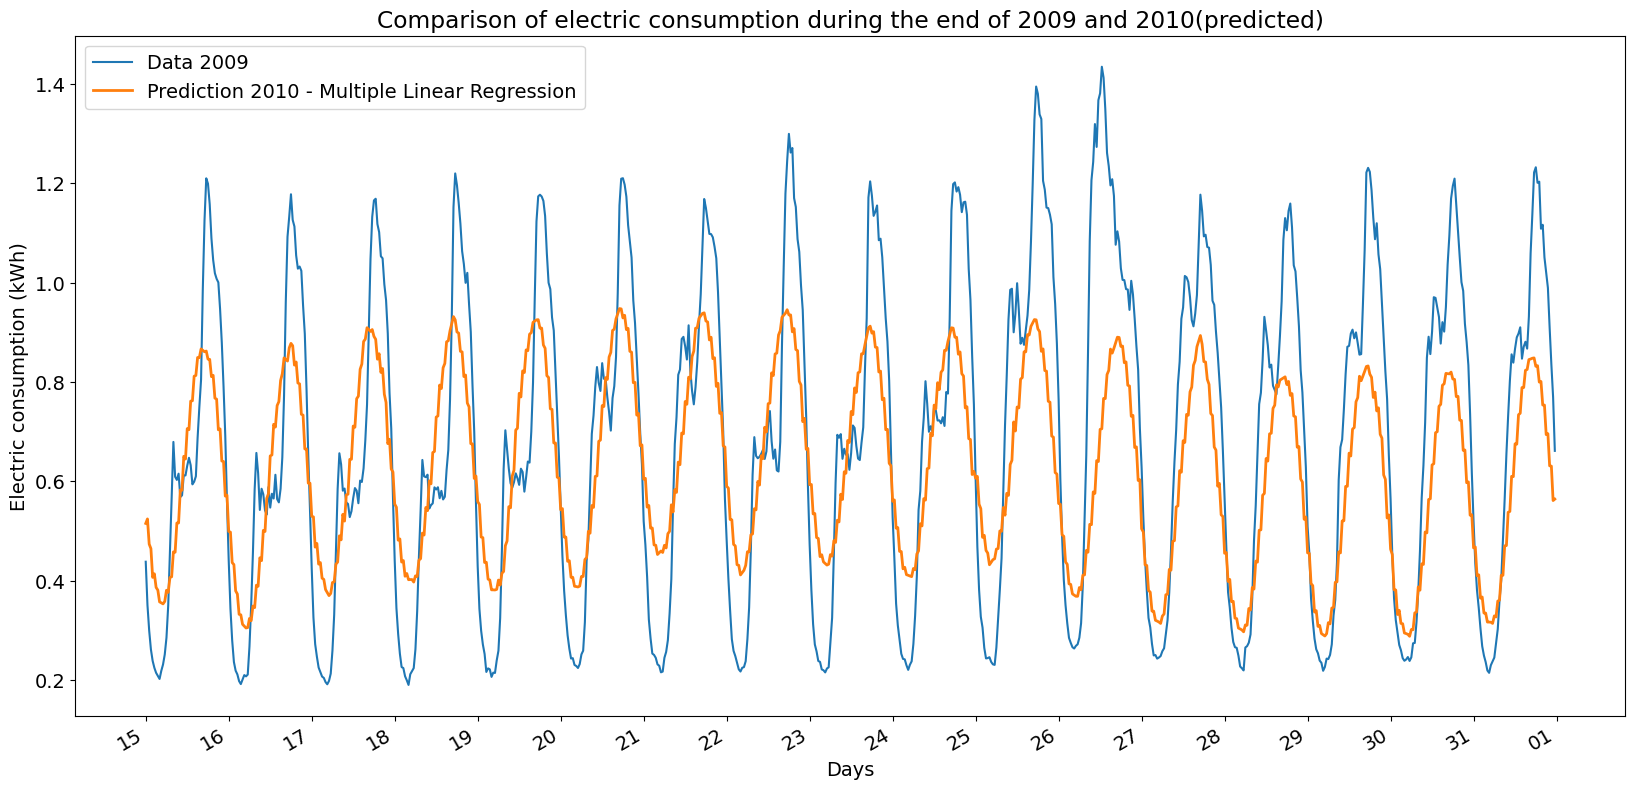

In [ ]:
date_rng = pd.date_range(start='2010-12-15', end='2010-12-31 23:59:59', freq='30T')

fig, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(20,10))
plt.gcf().autofmt_xdate()
plt.title("Comparison of electric consumption during the end of 2009 and 2010(predicted)")
ax1.plot(date_rng, Y_dec09, label = 'Data 2009')
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d'))
ax1.xaxis.set_major_locator(plt.matplotlib.dates.DayLocator())
ax1.plot(date_rng, y, linewidth = 2, label = 'Prediction 2010 - Multiple Linear Regression')
ax1.legend(loc='upper left')
ax1.set_xlabel('Days')
ax1.set_ylabel('Electric consumption (kWh)')
plt.show()

In [ ]:
metrics.loc[len(metrics)]= ['Linear Regression','Réduite','80%','20%', ' - ', str(round(r2*100,2))+"%",str(round(mape*100,2))+"%"]

IV.2 Decision Tree Regressor


Pour ces modèles, on a divisé les premiers 80% des données pour training, et les derniers 20% pour testing

In [ ]:
train_size = int(0.8 * len(X))

# Splitting data
X_train, X_test = X[:train_size], X[train_size:]
XR_train, XR_test = XR[:train_size], XR[train_size:]
XN_train, XN_test = XN[:train_size], XN[train_size:]
XRN_train, XRN_test = XRN[:train_size], XRN[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

In [ ]:
modelX = DecisionTreeRegressor(random_state=42)
modelX.fit(X_train, Y_train)

modelXR = DecisionTreeRegressor(random_state=42)
modelXR.fit(XR_train, Y_train)

modelXN = DecisionTreeRegressor(random_state=42)
modelXN.fit(XN_train, Y_train)

modelXRN = DecisionTreeRegressor(random_state=42)
modelXRN.fit(XRN_train, Y_train)

# Predictions
Y_pred = modelX.predict(X_test)
t = [i for i in range(len(Y))]
YR_pred = modelXR.predict(XR_test)
YN_pred = modelXN.predict(XN_test)
YRN_pred = modelXRN.predict(XRN_test)

r2 = r2_score(Y_test, Y_pred)
mape = mean_absolute_percentage_error(Y_test,Y_pred)

print(f'R^2 Score X: {r2}')
print(f'MAPE Score X: {mape}\n')
metrics.loc[len(metrics)]= ['Decision Tree','Complète','80%','20%', ' - ', str(round(r2*100,2))+'%',str(round(mape*100,2))+'%']

r2 = r2_score(Y_test, YR_pred)
mape = mean_absolute_percentage_error(Y_test,YR_pred)

print(f'R^2 Score XR: {r2}')
print(f'MAPE Score XR: {mape}\n')
metrics.loc[len(metrics)]= ['Decision Tree','Réduite','80%','20%', ' - ', str(round(r2*100,2))+'%',str(round(mape*100,2))+'%']

r2 = r2_score(Y_test, YN_pred)
mape = mean_absolute_percentage_error(Y_test,YN_pred)

print(f'R^2 Score XN: {r2}')
print(f'MAPE Score XN: {mape}\n')
metrics.loc[len(metrics)]= ['Decision Tree','Normalisé','80%','20%', ' - ', str(round(r2*100,2))+'%',str(round(mape*100,2))+'%']

r2 = r2_score(Y_test, YRN_pred)
mape = mean_absolute_percentage_error(Y_test,YRN_pred)

print(f'R^2 Score XRN: {r2}')
print(f'MAPE Score XRN: {mape}')
metrics.loc[len(metrics)]= ['Decision Tree','Réduite Normalisé','80%','20%', ' - ', str(round(r2*100,2))+'%',str(round(mape*100,2))+'%']


R^2 Score X: 0.8834655743462818
MAPE Score X: 0.11149596544741017

R^2 Score XR: 0.8854897548425937
MAPE Score XR: 0.11127452711083036

R^2 Score XN: 0.8836334927588058
MAPE Score XN: 0.11136894724805133

R^2 Score XRN: 0.8846778803461268
MAPE Score XRN: 0.11162251257152629


IV.3 Decision Tree Regressor with Cross Validation


Avec la Cross-Validation, on peut choisir une quantité de splits pour faire l'entraînement. Avec 35 splits, on trouve des bons résultats en moyenne, mais la grande quantité de splits diminue la taille des ensembles d'entraînement et résulte en grande variance des erreurs MAPE et R²

In [ ]:
tscv = TimeSeriesSplit(n_splits=35)

# Listes pour stocker les metriques
r2XRN_scores = []
mapeXRN_scores= []

# Cross-validation
for train_index, test_index in tscv.split(XRN):
    X_train, X_test = XRN.iloc[train_index], XRN.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Création et entraînement du modèle
    model = DecisionTreeRegressor(random_state=42)
    model.fit(X_train, Y_train)

    # Prévisions dans le modèle
    Y_pred = model.predict(X_test)

    # Calcul des métriques
    r2 = r2_score(Y_test, Y_pred)
    mape = mean_absolute_percentage_error(Y_test, Y_pred)

    r2XRN_scores.append(r2)
    mapeXRN_scores.append(mape)

# Résultats moyens
mean_r2XRN = np.mean(r2XRN_scores)
mean_mapeXRN = np.mean(mapeXRN_scores)

print(f'Mean R^2 across folds XRN: {mean_r2XRN}')
print(f'R^2 across all folds XRN: {r2XRN_scores}')
print(f'Mean MAPE across folds XRN: {mean_mapeXRN}')
print(f'MAPE across all folds XRN: {mapeXRN_scores}\n')

metrics.loc[len(metrics)]= ['Decision Tree + Cross Validation','Réduite Normalisé','34 splits','1 split', ' Haute variance des métriques ', str(round(mean_r2XRN*100,2))+'%',str(round(mean_mapeXRN*100,2))+'%']

Mean R^2 across folds XRN: 0.8658558819254464
R^2 across all folds XRN: [0.8971772268687404, 0.9163944351574166, 0.870842053054315, 0.9071521743405819, 0.8939370623414866, 0.9183360835858119, 0.8776519767140034, 0.9300705503480694, 0.9263866148659732, 0.9173312048980105, 0.7165182783072066, 0.8554406874027414, 0.8259705640427601, 0.8785343460216024, 0.8670946918431903, 0.8705604636544401, 0.7975724484611001, 0.7259992118305474, 0.8053362383042437, 0.8449722244373314, 0.7986760743112145, 0.8583936899210953, 0.8318038617763257, 0.8827087958276473, 0.9069932751782877, 0.8686614486641301, 0.8430972099136116, 0.8753602353737828, 0.9072755794432796, 0.8895113203379984, 0.858356445328547, 0.9036896931097973, 0.87808259922644, 0.874845744004097, 0.8842213584947978]
Mean MAPE across folds XRN: 0.10912749280199188
MAPE across all folds XRN: [0.09160884070507135, 0.08163013189629939, 0.09847533478250069, 0.09421425710900412, 0.09714579114015662, 0.08616758267424, 0.10568906276983298, 0.0909628830

On peut voir un MAPE moyen de 0.109, mais dans la liste on voit des valeurs entre 0.08 et 0.17

IV.4 Random Forest Regressor

Pour ces modèles, on a aussi divisé les premiers 80% des données pour training, et les derniers 20% pour testing

In [ ]:
train_size = int(0.8 * len(X))

# Splitting data
X_train, X_test = X[:train_size], X[train_size:]
XR_train, XR_test = XR[:train_size], XR[train_size:]
XN_train, XN_test = XN[:train_size], XN[train_size:]
XRN_train, XRN_test = XRN[:train_size], XRN[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

In [ ]:
modelX = RandomForestRegressor(random_state=42, n_estimators=10)
modelX.fit(X_train, Y_train)

modelXR = RandomForestRegressor(random_state=42, n_estimators=10)
modelXR.fit(XR_train, Y_train)

modelXN = RandomForestRegressor(random_state=42, n_estimators=10)
modelXN.fit(XN_train, Y_train)

modelXRN = RandomForestRegressor(random_state=42, n_estimators=10)
modelXRN.fit(XRN_train, Y_train)

# Predictions
Y_pred = modelX.predict(X_test)
YR_pred = modelXR.predict(XR_test)
YN_pred = modelXN.predict(XN_test)
YRN_pred = modelXRN.predict(XRN_test)

r2 = r2_score(Y_test, Y_pred)
mape = mean_absolute_percentage_error(Y_test,Y_pred)

print(f'R^2 Score X: {r2}')
print(f'MAPE Score X: {mape}\n')
metrics.loc[len(metrics)]= ['Random Forest','Complète','80%','20%', ' - ', str(round(r2*100,2))+'%',str(round(mape*100,2))+'%']

r2 = r2_score(Y_test, YR_pred)
mape = mean_absolute_percentage_error(Y_test,YR_pred)

print(f'R^2 Score XR: {r2}')
print(f'MAPE Score XR: {mape}\n')
metrics.loc[len(metrics)]= ['Random Forest','Réduite','80%','20%', ' - ', str(round(r2*100,2))+'%',str(round(mape*100,2))+'%']

r2 = r2_score(Y_test, YN_pred)
mape = mean_absolute_percentage_error(Y_test,YN_pred)

print(f'R^2 Score XN: {r2}')
print(f'MAPE Score XN: {mape}\n')
metrics.loc[len(metrics)]= ['Random Forest','Normalisé','80%','20%', ' - ', str(round(r2*100,2))+'%',str(round(mape*100,2))+'%']

r2 = r2_score(Y_test, YRN_pred)
mape = mean_absolute_percentage_error(Y_test,YRN_pred)

print(f'R^2 Score XRN: {r2}')
print(f'MAPE Score XRN: {mape}')
metrics.loc[len(metrics)]= ['Random Forest','Réduite Normalisé','80%','20%', ' - ', str(round(r2*100,2))+'%',str(round(mape*100,2))+'%']



R^2 Score X: 0.9348243722858564
MAPE Score X: 0.08645905484382961

R^2 Score XR: 0.9367459062800552
MAPE Score XR: 0.08500500873604433

R^2 Score XN: 0.9346941163555162
MAPE Score XN: 0.08654766451930569

R^2 Score XRN: 0.9366537586972616
MAPE Score XRN: 0.0851014391119699


Dans le cadre de ce modèle, on a essayé d'utiliser 20% de données comme test, plus le mois de Janvier/2010. Le reste a été utilisé par l'entraînement

In [ ]:
# Choosing the period to select
start_date = '2010-01-01 00:00:00'
end_date = '2010-01-31 23:59:59'

# Filter the DataFrame to obtain the data for the time period
mask_within_period = (X_full['date'] >= start_date) & (X_full['date'] <= end_date)
df_15_days = X_full.loc[mask_within_period]

# Filter the DataFrame to obtain the data outside the time period
mask_outside_period = (X_full['date'] < start_date) | (X_full['date'] > end_date)
df_rest = X_full.loc[mask_outside_period]

Y_15 = df_15_days['mean']
X_15 = df_15_days.drop(columns=['date','mean']);
Y_rest = df_rest['mean']
X_rest = df_rest.drop(columns=['date','mean']);


mask = (X_full['date'] >= '2009-12-15') & (X_full['date'] <= '2009-12-31 23:59:59')
df_dec09 = X_full.loc[mask]
Y_dec09 = df_dec09['mean']


In [ ]:
train_size = int(0.8 * len(X))

# Splitting data
X_trainO, X_testO = X_rest[:train_size], X_rest[train_size:]
Y_trainO, Y_testO = Y_rest[:train_size], Y_rest[train_size:]

model_O = RandomForestRegressor(random_state=42, n_estimators=10)
model_O.fit(X_trainO, Y_trainO)

# Predictions
Y_pred = model_O.predict(X_testO)
Y_pred15 = model_O.predict(X_15)

r2 = r2_score(Y_testO, Y_pred)
mape = mean_absolute_percentage_error(Y_testO,Y_pred)

print(f'R^2 Score: {r2}')
print(f'MAPE Score: {mape}\n')
metrics.loc[len(metrics)]= ['Random Forest','Complète','80%','20%', ' Janvier/2010 utilisé par tests ', str(round(r2*100,2))+'%',str(round(mape*100,2))+'%']

r2 = r2_score(Y_15, Y_pred15)
mape = mean_absolute_percentage_error(Y_15, Y_pred15)

print(f'R^2 Score in 01/2010: {r2}')
print(f'MAPE Score in 01/2010: {mape}')



R^2 Score: 0.9381320466980843
MAPE Score: 0.08683288689173023

R^2 Score in 01/2010: 0.8898589559670873
MAPE Score in 01/2010: 0.11469255612164657


Cette division nous permet d'avoir MAPE = 0.084 en général, et spécifiquement MAPE 0.113 dans la période de janvier, qui a des caractéristiques proches de la période que nous voudrions prévoir

Dans la suite, on voit la comparaison entre les données réeles et prévus

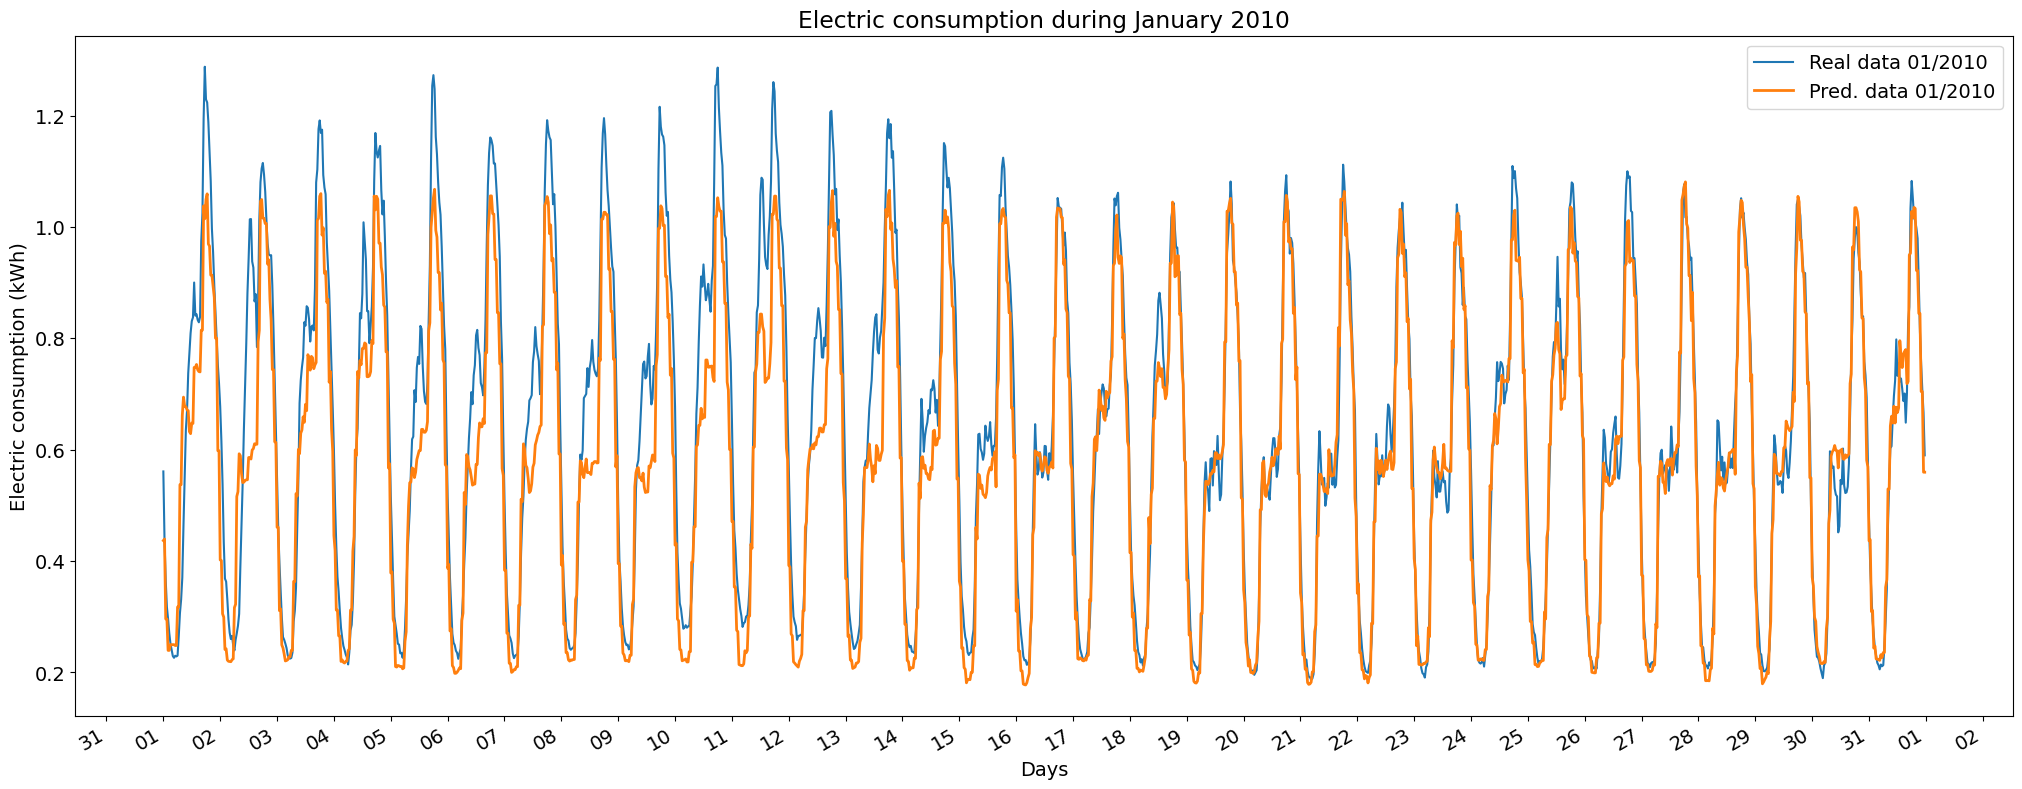

In [ ]:
fig, ax = plt.subplots(figsize=(25,10))
time = df_time[(df_time.dt.month == 1) & (df_time.dt.year == 2010)] # & (df_time.dt.day >= 15)]# & (df1['time'].dt.day < 28)]
ax.plot(time, Y_15, label = "Real data 01/2010")
ax.plot(time, Y_pred15, linewidth = 2, label = "Pred. data 01/2010")
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d'))
ax.xaxis.set_major_locator(plt.matplotlib.dates.DayLocator())
plt.gcf().autofmt_xdate()
plt.title("Electric consumption during January 2010")
plt.xlabel('Days')
plt.ylabel('Electric consumption (kWh)')
plt.legend()

Après, on peut aussi voir une comparaison entre la même période de 2009 et la prévision pour 15 à 31/12/2010

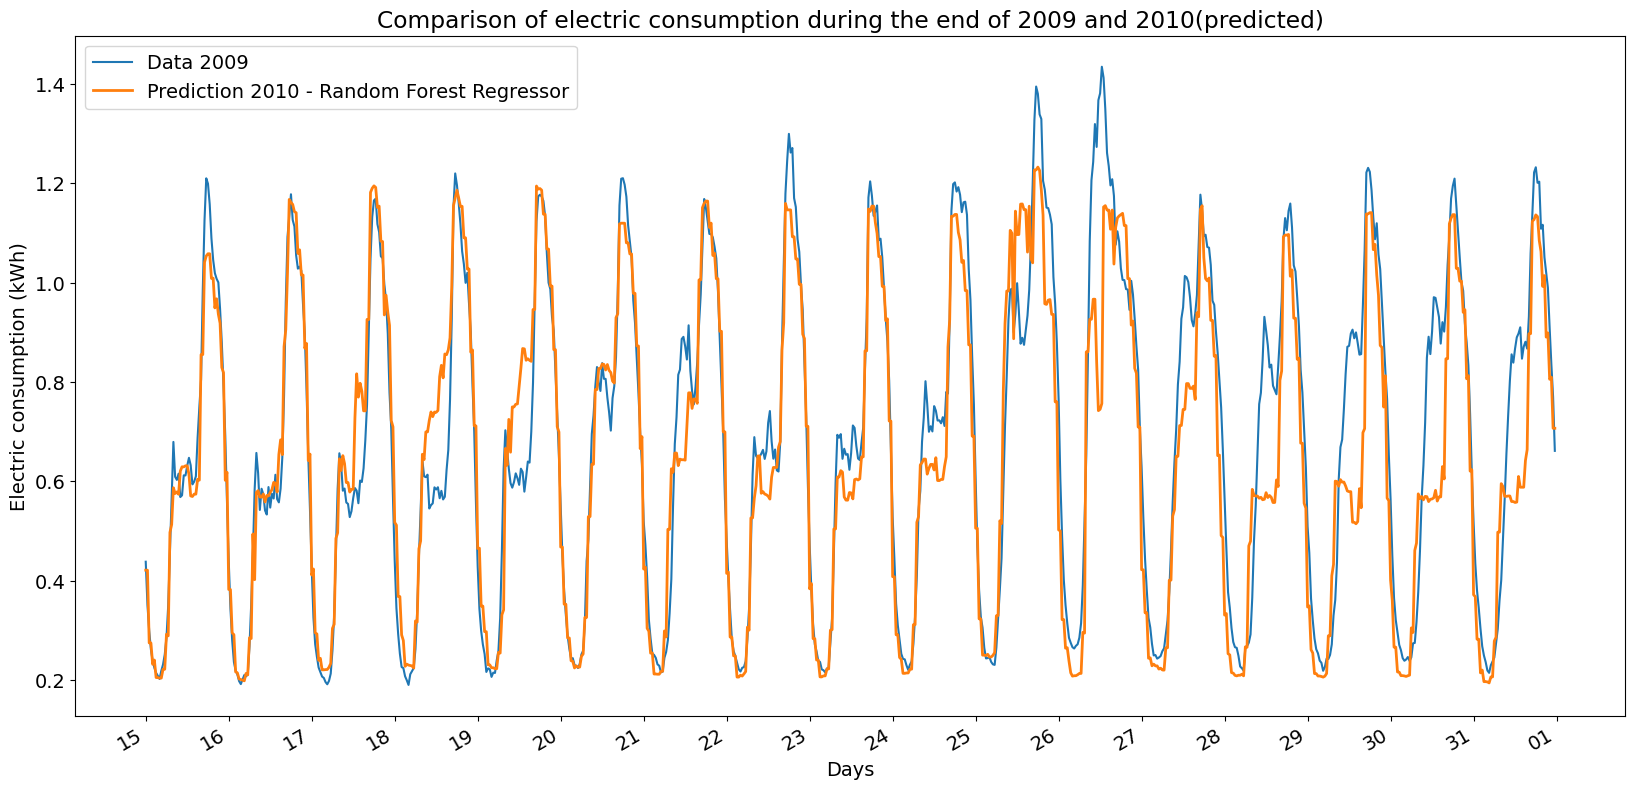

In [ ]:
date_rng = pd.date_range(start='2010-12-15', end='2010-12-31 23:59:59', freq='30T')

Y_valid_O = model_O.predict(X_valid)

fig, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(20,10))
plt.gcf().autofmt_xdate()
plt.title("Comparison of electric consumption during the end of 2009 and 2010(predicted)")
ax1.plot(date_rng, Y_dec09, label = 'Data 2009')
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d'))
ax1.xaxis.set_major_locator(plt.matplotlib.dates.DayLocator())
ax1.plot(date_rng, Y_valid_O, linewidth = 2, label = 'Prediction 2010 - Random Forest Regressor')
ax1.legend(loc='upper left')
ax1.set_xlabel('Days')
ax1.set_ylabel('Electric consumption (kWh)')
plt.show()


##IV.5) Séries temporelles (SARIMAX)

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO
# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

In [ ]:
XRN.columns

Index(['temp_x', 'ind', 'rain', 'ind.1', 'msl', 'wdsp', 'wddir', 'w', 'sun',
       'is_holiday', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
       'day_of_week_sin', 'day_of_week_cos'],
      dtype='object')

In [ ]:
XRN_ts = XRN.drop(columns = ['month_sin', 'month_cos', 'hour_sin', 'hour_cos',
       'day_of_week_sin', 'day_of_week_cos'])
XRN_ts.head()

temp_x       ind      rain    ind.1       msl      wdsp     wddir  \
0  0.408508  1.712816 -0.268352 -0.22353 -0.811092 -0.696713  1.004252   
1  0.389005  1.712816 -0.268352 -0.22353 -0.782984 -0.696713  1.004252   
2  0.369502  1.712816 -0.268352 -0.22353 -0.754876 -0.696713  1.004252   
3  0.349999  1.712816 -0.170718 -0.22353 -0.718737 -0.589331  0.891961   
4  0.330496  1.712816 -0.073084 -0.22353 -0.682599 -0.481950  0.779669   

          w       sun  is_holiday  
0  2.017933 -0.559234           0  
1  0.655843 -0.559234           0  
2 -0.706247 -0.559234           0  
3 -0.706247 -0.559234           0  
4 -0.706247 -0.559234           0

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

Y_train, Y_test = Y[:(len(Y)-816)], Y[(len(Y)-816):]
X_train = XRN_ts[:(len(Y)-816)]
X_test = XRN_ts[(len(Y)-816):]
# Fit the model
mod = sm.tsa.statespace.SARIMAX(Y_train, trend='ct', order=(1,1,1), exog = X_train)
res = mod.fit(disp=False)
#print(res.summary())

#res.plot_diagnostics(figsize=(15, 12))

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAPE = 0.3093404748956045
MSE = 0.07069762617610553
R2 = 0.09381501551071281


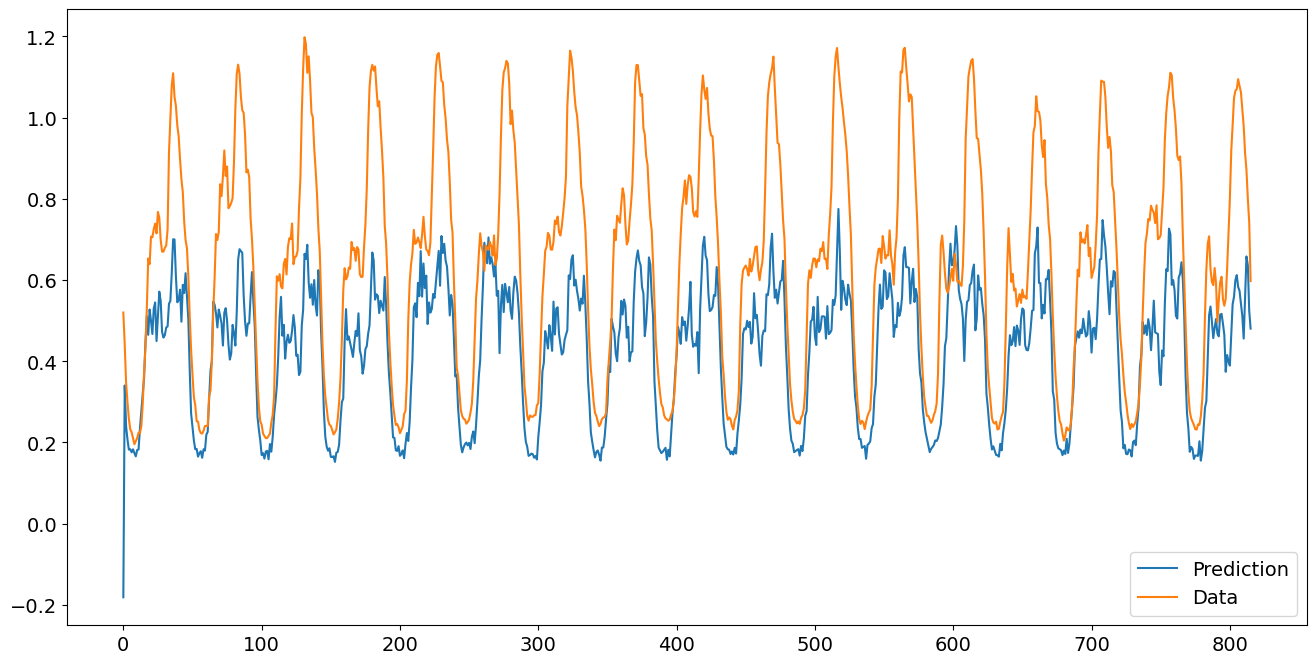

In [ ]:
t = [i for i in range(len(Y_test))]
Y_pred = res.predict(0, len(t)-1, exog = X_test)
print("MAPE =", mean_absolute_percentage_error(Y_test,Y_pred))
print("MSE =", mean_squared_error(Y_test,Y_pred))
print("R2 =", r2_score(Y_test,Y_pred))
metrics.loc[len(metrics)]= ['SARIMAX','Réduite Normalisé','07/2009-11/2010','Dernières 2 semaines', ' - ', str(round(r2_score(Y_test,Y_pred)*100,2))+'%',str(round(mean_absolute_percentage_error(Y_test,Y_pred)*100,2))+'%']
plt.plot(t, Y_pred, label = 'Prediction')
plt.plot(t, Y_test, label = 'Data')
plt.legend()

In [ ]:
mod_final = sm.tsa.statespace.SARIMAX(Y, trend='ct', order=(1,0,1), exog = XRN_ts)
res_final = mod.fit(disp=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


##IV.6) Multi-layer Perceptron (MLP)


Division onto a training and test set:

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

def split_data_simple(X, train_percentage = 0.8):
  '''The first 80% is reserved for the training set and the 20% left to the test set'''
  train_size = int(train_percentage*len(X))
  return X[:train_size], X[train_size:]

def split_data(X, n = 0):
  '''n should belong to [0,1,2,3,4]
  For instance with n = 1 the part between 60% and 80% is reserved to the test set,
  the rest is left to the training set'''
  train_percentage = 0.8
  if n==0:
    train_size = int(train_percentage*len(X))
    return X[:train_size], X[train_size:]
  else:
    test_percentage = 1 - train_percentage
    div1 = int((train_percentage - n*test_percentage)*len(X))
    div2 = int((train_percentage - (n-1)*test_percentage)*len(X))
    return pd.concat([X[:div1], X[div2:]]), X[div1:div2]

# Splitting the data
X_train, X_test = split_data(XRN, 0)
Y_train, Y_test = split_data(Y,0)

Search for the best hyperparameters with GridSearchCV:

In [ ]:
# THIS CELL TAKES A LONG TIME TO RUN

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

parameters = { 'hidden_layer_sizes': [(10,50,10,), (10,10,), (100,), (10,10,10,), (50,)],
              'activation': ['relu','logistic'],
               'solver': ['lbfgs', 'adam']}
regr = MLPRegressor()
clf = GridSearchCV(regr, parameters)
search = clf.fit(X_train, Y_train)

In [ ]:
print(search.best_params_)

The best parameters found were

activation: 'relu',

hidden_layer_sizes: (10, 10, 10),

solver: 'lbfgs'

Train of the model, and performance computation:

Score = 0.9291591255152645
MAPE = 0.09466829224759735
MSE = 0.0038805695469650886
R2 = 0.9291591255152645


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


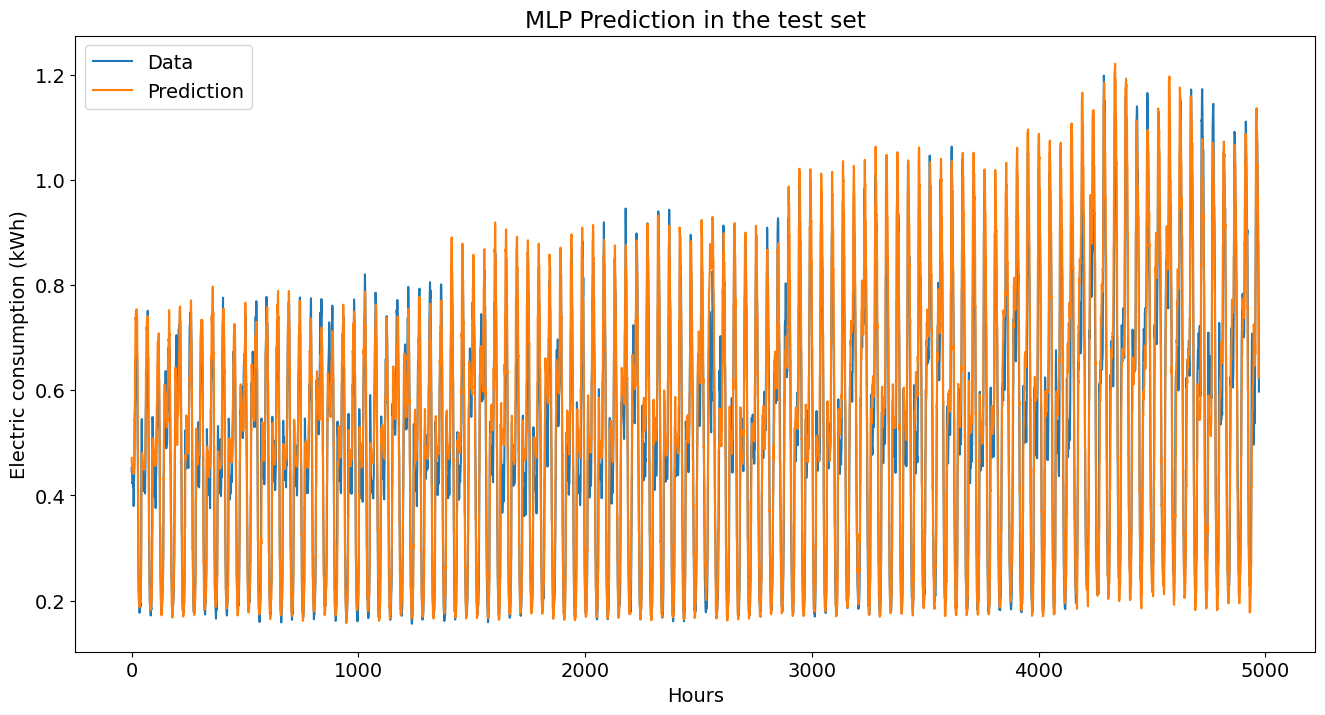

In [ ]:
regr = MLPRegressor(hidden_layer_sizes = (10,10,10,), activation = 'relu', solver = 'lbfgs', random_state=None, max_iter=500).fit(X_train, Y_train)
Y_pred = regr.predict(X_test)
print("Score =", regr.score(X_test, Y_test))
print("MAPE =", mean_absolute_percentage_error(Y_test,Y_pred))
print("MSE =", mean_squared_error(Y_test,Y_pred))
print("R2 =", r2_score(Y_test,Y_pred))

metrics.loc[len(metrics)]= ['MLPE','Réduite Normalisé','80%','20%', ' - ', str(round(r2_score(Y_test,Y_pred)*100,2))+'%',str(round(mean_absolute_percentage_error(Y_test,Y_pred)*100,2))+'%']
import matplotlib.pyplot as plt

x_axis = [i for i in range(len(Y_test))]
plt.plot(x_axis, Y_test, label = 'Data')
plt.plot(x_axis, Y_pred, label = 'Prediction')
plt.xlabel('Hours')
plt.ylabel('Electric consumption (kWh)')
plt.title('MLP Prediction in the test set')
plt.legend()

In this cell we divide the training set in five different ways (always keeping the 80/20 proportion) and compute the mean of the metrics, to see how well the model can predict different periods of time.

In [ ]:
MAPE_sum = 0
MSE_sum = 0
R2_sum = 0
for i in range(5):
  X_train, X_test = split_data(XRN, i)
  Y_train, Y_test = split_data(Y,i)
  regr = MLPRegressor(hidden_layer_sizes = (10,10,10,), activation = 'relu', solver = 'lbfgs', random_state=None, max_iter=500).fit(X_train, Y_train)
  Y_pred = regr.predict(X_test)
  MAPE = mean_absolute_percentage_error(Y_test,Y_pred)
  MSE = mean_squared_error(Y_test,Y_pred)
  R2 = r2_score(Y_test,Y_pred)
  #print("MAPE =", MAPE)
  #print("MSE =", MSE)
  #print("R2 =", R2)
  MAPE_sum += MAPE
  MSE_sum += MSE
  R2_sum += R2

print("Mean MAPE =", MAPE_sum/5)
print("Mean MSE =", MSE_sum/5)
print("Mean R2 =", R2_sum/5)



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

Mean MAPE = 0.09819902772243333
Mean MSE = 0.004587768409372339
Mean R2 = 0.9068373124411468


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP Prediction of the electric consumption in the final december of 2010:

In [ ]:
regr = MLPRegressor(hidden_layer_sizes = (10,10,10,), activation = 'relu', solver = 'lbfgs', random_state=None, max_iter=500).fit(X_train, Y_train)
MLP_prediction = regr.predict(X_valid_RN)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


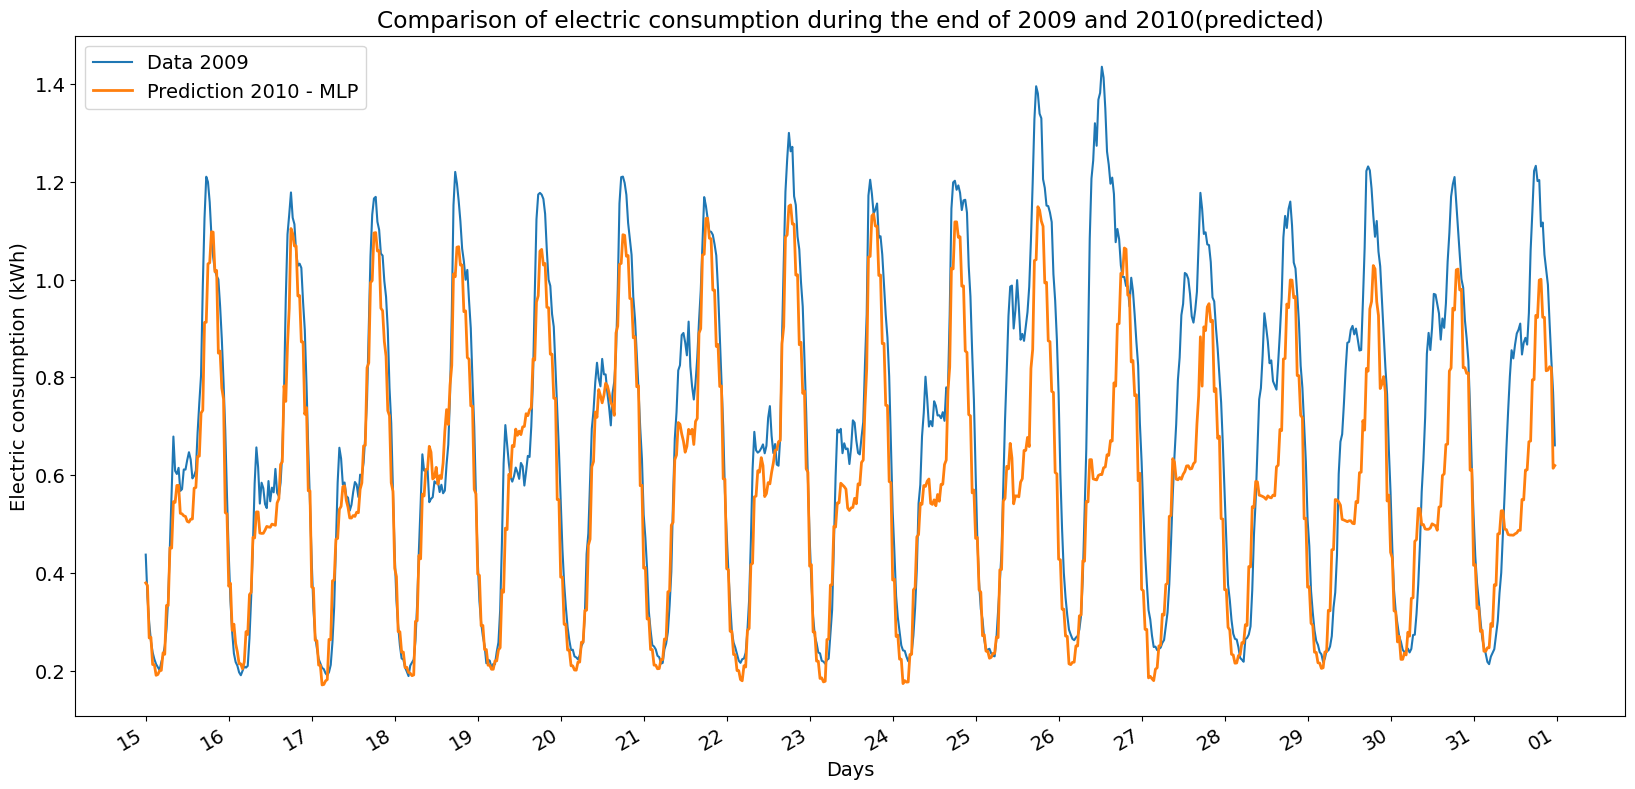

In [ ]:
date_rng = pd.date_range(start='2010-12-15', end='2010-12-31 23:59:59', freq='30T')

fig, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(20,10))
plt.gcf().autofmt_xdate()
plt.title("Comparison of electric consumption during the end of 2009 and 2010(predicted)")
ax1.plot(date_rng, Y_dec09, label = 'Data 2009')
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d'))
ax1.xaxis.set_major_locator(plt.matplotlib.dates.DayLocator())
ax1.plot(date_rng, MLP_prediction, linewidth = 2, label = 'Prediction 2010 - MLP')
ax1.legend(loc='upper left')
ax1.set_xlabel('Days')
ax1.set_ylabel('Electric consumption (kWh)')
plt.show()

In [ ]:
metrics

Model         DF Utilisé      Train Split   \
0                  Linear Regression            Réduite              80%   
1                      Decision Tree           Complète              80%   
2                      Decision Tree            Réduite              80%   
3                      Decision Tree          Normalisé              80%   
4                      Decision Tree  Réduite Normalisé              80%   
5   Decision Tree + Cross Validation  Réduite Normalisé        34 splits   
6                      Random Forest           Complète              80%   
7                      Random Forest            Réduite              80%   
8                      Random Forest          Normalisé              80%   
9                      Random Forest  Réduite Normalisé              80%   
10                     Random Forest           Complète              80%   
11                           SARIMAX  Réduite Normalisé  07/2009-11/2010   
12                              MLPE  Réduite Normalisé              80%   

             Test Split                           Remarks      R2    MAPE   
0                    20%                                -   68.46%  24.98%  
1                    20%                                -   88.35%  11.15%  
2                    20%                                -   88.55%  11.13%  
3                    20%                                -   88.36%  11.14%  
4                    20%                                -   88.47%  11.16%  
5                1 split     Haute variance des métriques   86.59%  10.91%  
6                    20%                                -   93.48%   8.65%  
7                    20%                                -   93.67%    8.5%  
8                    20%                                -   93.47%   8.65%  
9                    20%                                -   93.67%   8.51%  
10                   20%   Janvier/2010 utilisé par tests   93.81%   8.68%  
11  Dernières 2 semaines                                -    9.38%  30.93%  
12                   20%                                -   92.92%   9.47%

#V. Prévision Finale

Pour la prévision, on a choisi d'utiliser la moyenne entre les résultats de la réseau neuronne MLPE et le modèle Random Forest Regressor

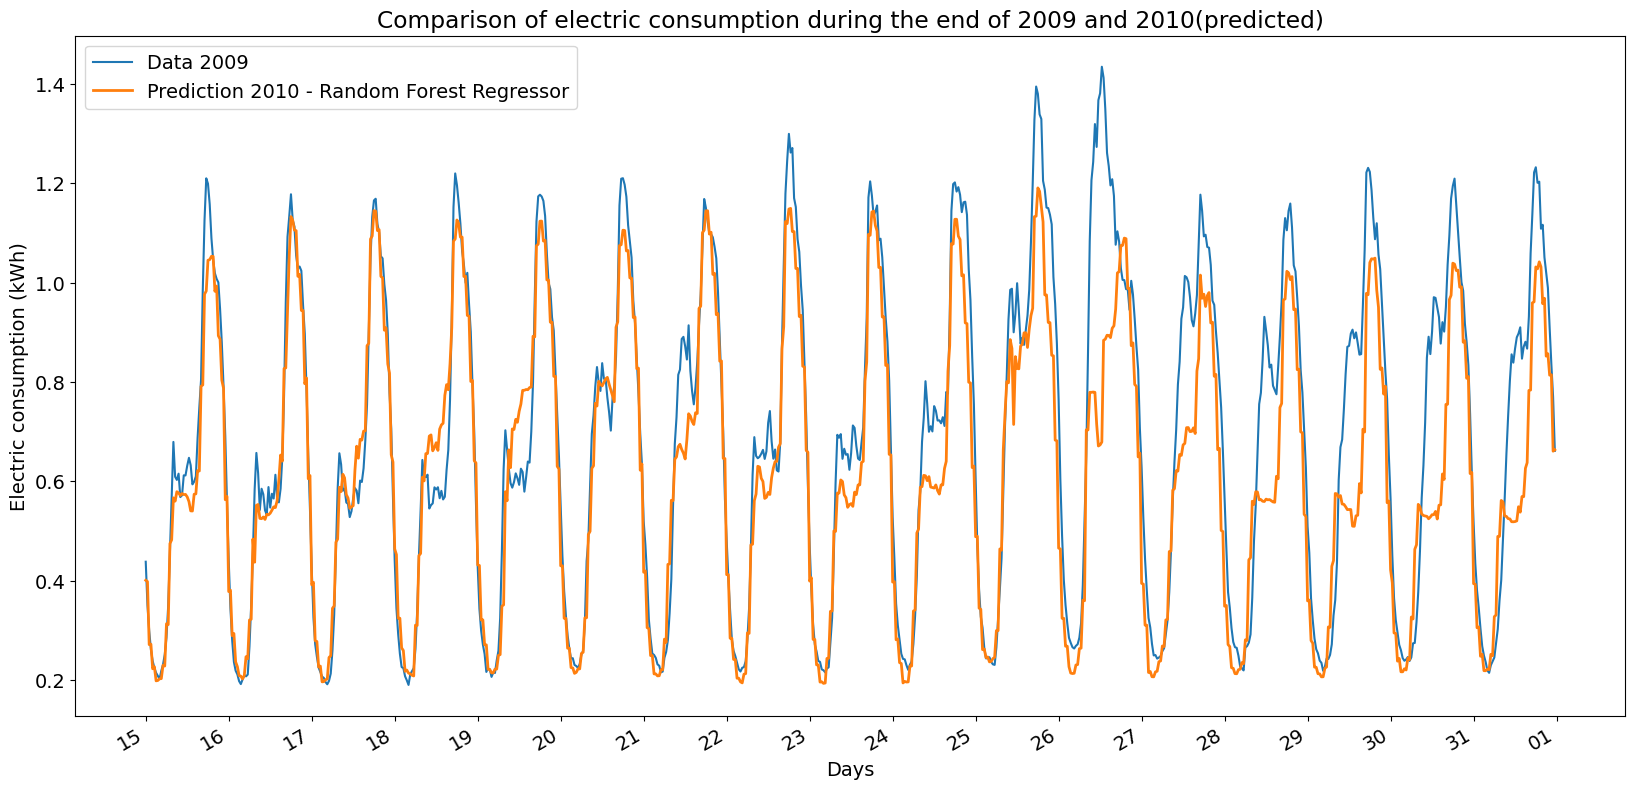

In [ ]:
df_mean = (MLP_prediction + Y_valid_O) / 2
date_rng = pd.date_range(start='2010-12-15', end='2010-12-31 23:59:59', freq='30T')

fig, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(20,10))
plt.gcf().autofmt_xdate()
plt.title("Comparison of electric consumption during the end of 2009 and 2010(predicted)")
ax1.plot(date_rng, Y_dec09, label = 'Data 2009')
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d'))
ax1.xaxis.set_major_locator(plt.matplotlib.dates.DayLocator())
ax1.plot(date_rng, df_mean, linewidth = 2, label = 'Prediction 2010 - Random Forest Regressor')
ax1.legend(loc='upper left')
ax1.set_xlabel('Days')
ax1.set_ylabel('Electric consumption (kWh)')
plt.show()

In [ ]:
df = pd.read_csv('df_vst_group5.csv')
data_change = df['mean']
data_change = data_change.dropna()
l1 = list(data_change)
l2 = list(df_mean)
l3 = l1+l2
df['mean'] = l3
df.to_csv('df_vst_group5.csv', index=False)